<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/CAMPANELLA_E4_ML_DL_45SEC_75OL_CROSS_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
import os

In [ ]:
# Percorso del file
file_path = "/content/drive/MyDrive/CROSS TEST/DATASET/CAMPANELLAETAL_E4_45SEC_750L.csv"

# Carica il dataset
df = pd.read_csv(file_path)

# Mostra info di base
print("Shape del dataset:", df.shape)
df.head()

Shape del dataset: (5197, 34)


,HRV_MeanNN,HRV_SDNN,HRV_MedianNN,HRV_MadNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_pNN50,HRV_MinNN,HRV_HTI,HRV_TINN,...,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,AccMag_Mean,AccMag_Std,AccMag_IQR,AccMag_Skew,AccMag_Kurtosis,Temp_Mean,Temp_Std,Temp_Slope
0,851.409314,397.383687,796.8750,231.656250,0.726941,593.750,84.313725,328.125,8.500000,515.625,...,10.0,0.474759,65.811918,2.140918,1.452823,0.297350,22.383226,32.691465,0.032216,0.000030
1,784.319196,257.132275,804.6875,243.239062,0.987672,578.125,73.214286,312.500,9.333333,531.250,...,9.0,0.049423,66.139587,1.372693,0.748424,0.292738,19.201590,32.717677,0.031517,0.000033
2,811.631944,300.605237,804.6875,312.735937,0.926961,546.875,81.481481,312.500,18.000000,15.625,...,9.0,0.047288,66.020477,1.456172,0.850274,0.447230,15.553015,32.738354,0.031784,0.000035
3,791.573661,274.529504,789.0625,266.404688,0.775029,546.875,76.785714,312.500,18.666667,218.750,...,10.0,0.072174,65.917027,1.871208,0.828314,-0.531419,24.924148,32.756659,0.026908,0.000026
4,816.550926,274.170349,796.8750,231.656250,0.707679,596.875,79.629630,328.125,13.500000,484.375,...,10.0,0.077495,65.867743,1.868495,0.873714,-0.536302,24.738033,32.774609,0.018653,0.000016


In [ ]:
for col in df.columns:
  print(col)

HRV_MeanNN
HRV_SDNN
HRV_MedianNN
HRV_MadNN
HRV_SDRMSSD
HRV_Prc20NN
HRV_pNN50
HRV_MinNN
HRV_HTI
HRV_TINN
HRV_MFDFA_alpha1_Max
HRV_MFDFA_alpha1_Fluctuation
HRV_SampEn
HRV_FuzzyEn
HRV_MSEn
HRV_CD
HRV_HFD
HRV_KFD
HRV_LZC
PPG_Amplitude
PPG_Duration
label
subject
protocol_phase
SCR_Peaks_N
SCR_Peaks_Amplitude_Mean
AccMag_Mean
AccMag_Std
AccMag_IQR
AccMag_Skew
AccMag_Kurtosis
Temp_Mean
Temp_Std
Temp_Slope


In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Absolut Frequency': freq_assolute,
    'Relative Frequency (%)': freq_relative.round(2)*100
})

frequency_table

,Absolut Frequency,Relative Frequency (%)
label,,
1,3457,67.0
0,1740,33.0


In [ ]:
counts = df.groupby(['subject', 'label']).size().unstack(fill_value=0)

counts['Totale'] = counts.sum(axis=1)

counts['Freq_Label_1 (%)'] = (counts[0] / counts['Totale'] * 100).round(2)
counts['Freq_Label_2 (%)'] = (counts[1] / counts['Totale'] * 100).round(2)

counts = counts.rename(columns={0: 'Baseline', 1: 'Stress'})

counts.reset_index(inplace=True)
counts

label,subject,Baseline,Stress,Totale,Freq_Label_1 (%),Freq_Label_2 (%)
0,subject_01,62,146,208,29.81,70.19
1,subject_02,60,133,193,31.09,68.91
2,subject_03,62,106,168,36.90,63.10
3,subject_04,62,109,171,36.26,63.74
4,subject_05,64,109,173,36.99,63.01
5,subject_06,61,114,175,34.86,65.14
6,subject_07,62,112,174,35.63,64.37
7,subject_08,64,121,185,34.59,65.41
8,subject_09,61,122,183,33.33,66.67
9,subject_10,62,120,182,34.07,65.93


In [ ]:
sum(df.isna().sum())

0

LOSO LOGISTIC REGRESSION

=== LOSO LOGISTIC REGRESSION ===
Samples: 5197, Features: 31, Subjects: 29

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - subject_01: F1=0.780 Acc=0.659
 *** NUOVO BEST MODEL (F1=0.7802) ***  Fold  2 - subject_02: F1=0.627 Acc=0.513
  Fold  3 - subject_03: F1=0.767 Acc=0.750
  Fold  4 - subject_04: F1=0.773 Acc=0.708
  Fold  5 - subject_05: F1=0.854 Acc=0.832
 *** NUOVO BEST MODEL (F1=0.8543) ***  Fold  6 - subject_06: F1=0.858 Acc=0.789
 *** NUOVO BEST MODEL (F1=0.8582) ***  Fold  7 - subject_07: F1=0.794 Acc=0.667
  Fold  8 - subject_08: F1=0.792 Acc=0.681
  Fold  9 - subject_09: F1=0.784 Acc=0.760
  Fold 10 - subject_10: F1=0.806 Acc=0.714
  Fold 11 - subject_11: F1=0.949 Acc=0.936
 *** NUOVO BEST MODEL (F1=0.9493) ***  Fold 12 - subject_12: F1=0.792 Acc=0.703
  Fold 13 - subject_13: F1=0.798 Acc=0.750
  Fold 14 - subject_14: F1=0.771 Acc=0.718
  Fold 15 - subject_15: F1=0.887 Acc=0.860
  Fold 16 - subject_16: F1=0.821 Acc=0.734
  Fold 17 - subject_17: F1=0.753 Acc

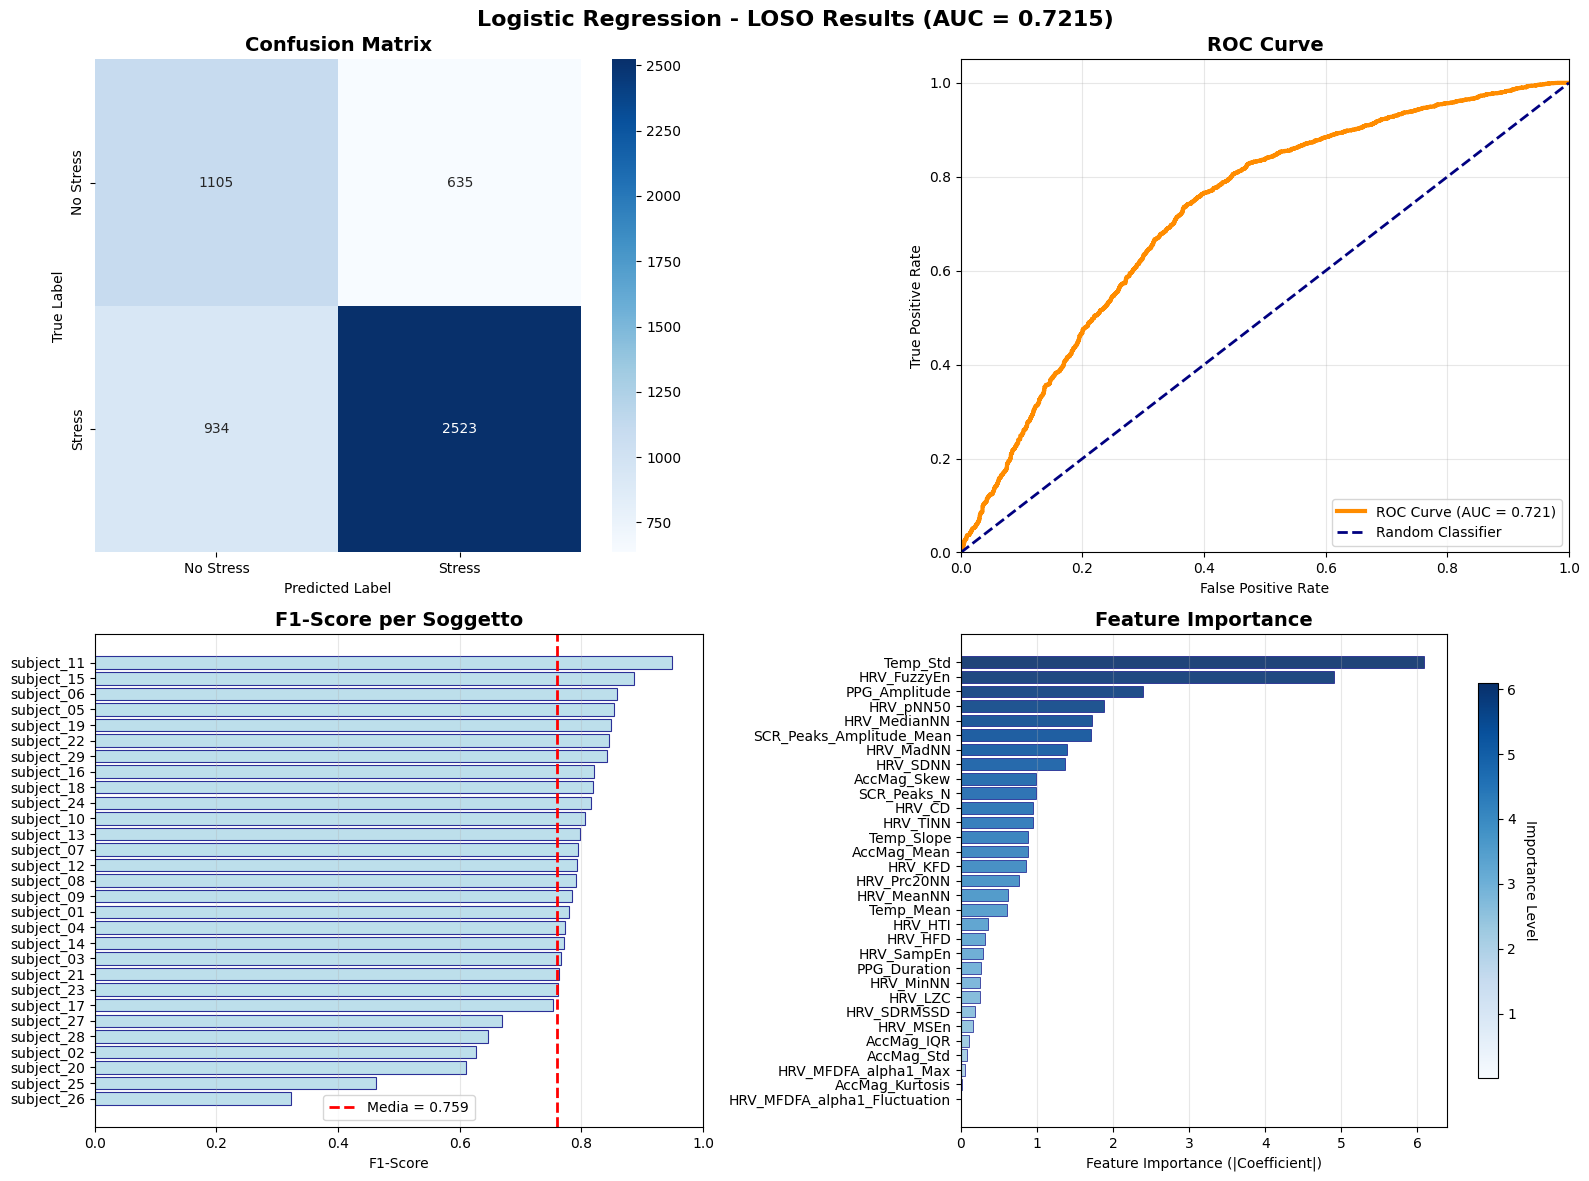


SUMMARY LOGISTIC REGRESSION LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.7591 ± 0.1270
AUC globale: 0.7215
Accuratezza globale: 0.6981
Range F1-Score: 0.3232 - 0.9493
Miglior soggetto: subject_11 (F1=0.9493)
Peggiore soggetto: subject_26 (F1=0.3232)

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 11
  Soggetto test: subject_11
  F1-Score: 0.9493
  Accuracy: 0.9364
  Precision: 0.9810
  Recall: 0.9196


In [ ]:
# =============================================================================
# LOSO LOGISTIC REGRESSION CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO LOGISTIC REGRESSION ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/LOGISTIC_REGRESSION"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "logistic_regression_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "logistic_regression_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "logistic_regression_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path}")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Logistic Regression - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Palette Graduale
if final_model is not None:
    # Calcola importance in valore assoluto
    coefficients = np.abs(final_model.coef_[0])  # Valore assoluto per same direction

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))  # Blues da 0.3 a 1.0 per evitare colori troppo chiari

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (|Coefficient|)')
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY LOGISTIC REGRESSION LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

RANDOM FOREST

=== LOSO RANDOM FOREST ===
Samples: 5197, Features: 31, Subjects: 29

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - subject_01: F1=0.806 Acc=0.692
 *** NUOVO BEST MODEL (F1=0.8061) ***  Fold  2 - subject_02: F1=0.752 Acc=0.611
  Fold  3 - subject_03: F1=0.845 Acc=0.810
 *** NUOVO BEST MODEL (F1=0.8447) ***  Fold  4 - subject_04: F1=0.824 Acc=0.737
  Fold  5 - subject_05: F1=0.848 Acc=0.809
 *** NUOVO BEST MODEL (F1=0.8479) ***  Fold  6 - subject_06: F1=0.823 Acc=0.720
  Fold  7 - subject_07: F1=0.790 Acc=0.661
  Fold  8 - subject_08: F1=0.807 Acc=0.692
  Fold  9 - subject_09: F1=0.763 Acc=0.694
  Fold 10 - subject_10: F1=0.814 Acc=0.703
  Fold 11 - subject_11: F1=0.844 Acc=0.821
  Fold 12 - subject_12: F1=0.790 Acc=0.687
  Fold 13 - subject_13: F1=0.773 Acc=0.670
  Fold 14 - subject_14: F1=0.754 Acc=0.667
  Fold 15 - subject_15: F1=0.860 Acc=0.817
 *** NUOVO BEST MODEL (F1=0.8595) ***  Fold 16 - subject_16: F1=0.823 Acc=0.728
  Fold 17 - subject_17: F1=0.810 Acc=0.689

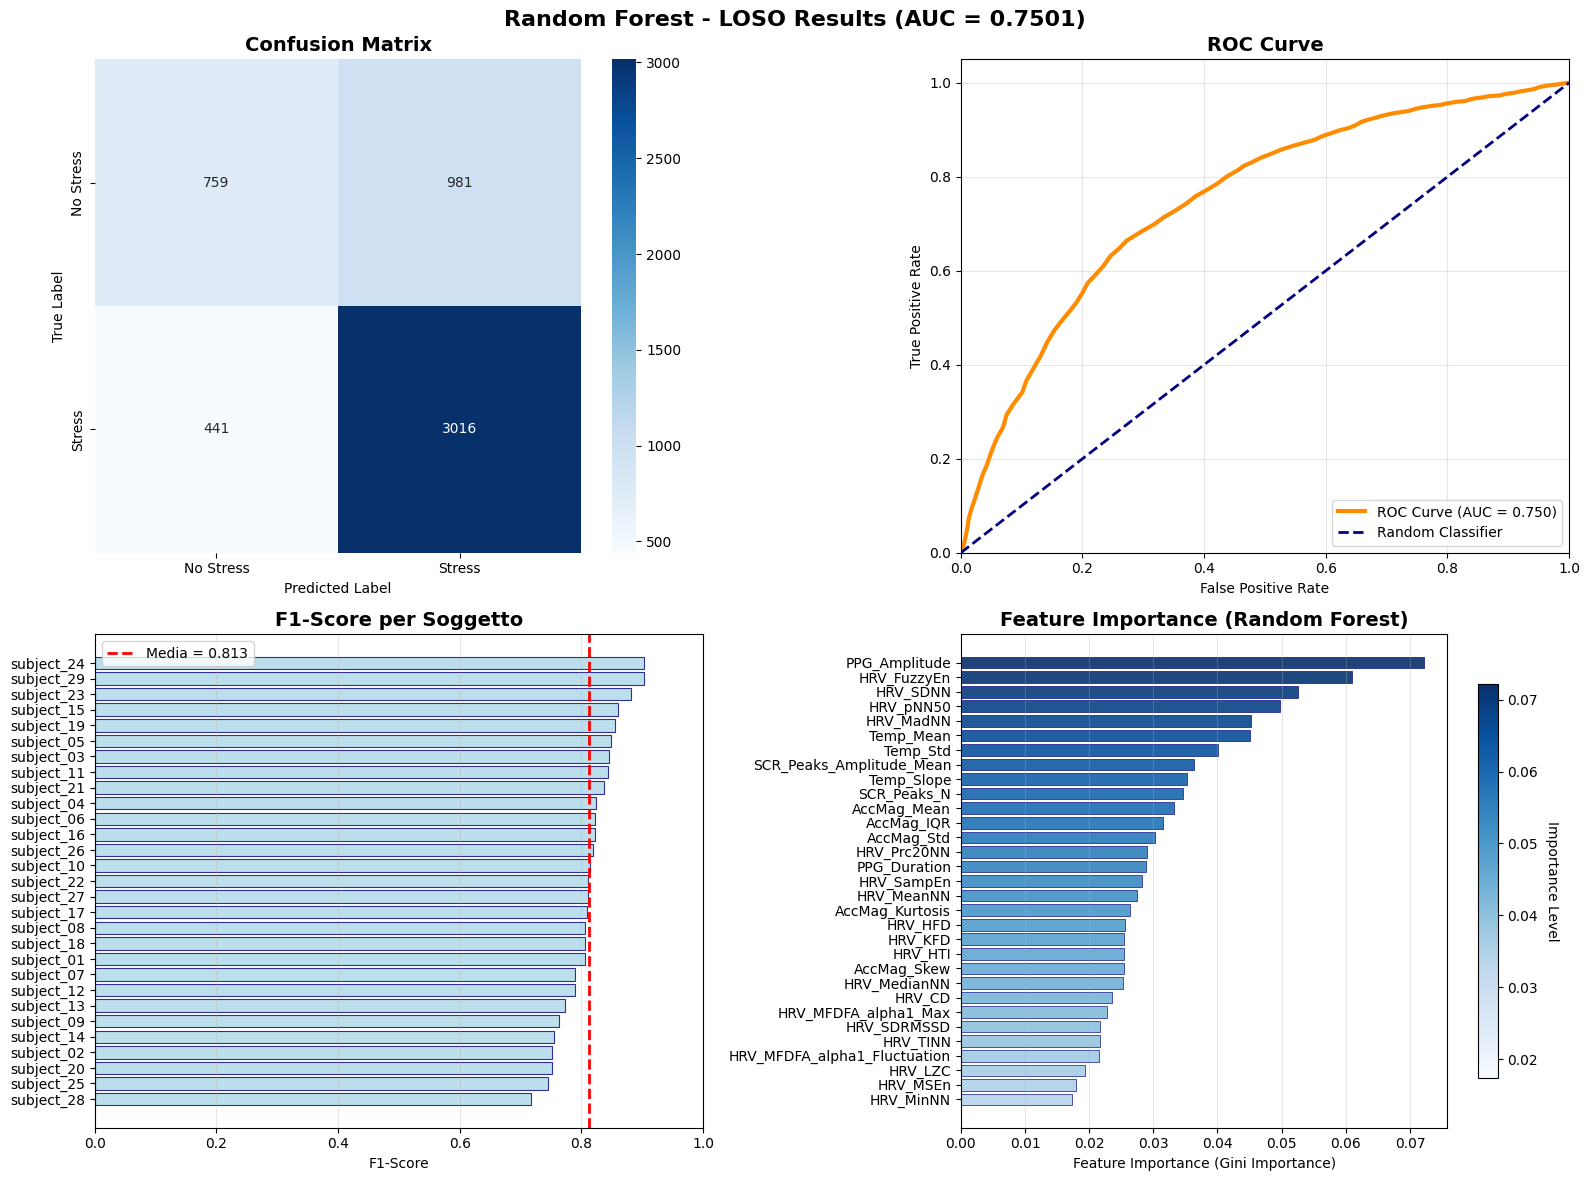


SUMMARY RANDOM FOREST LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8127 ± 0.0460
AUC globale: 0.7501
Accuratezza globale: 0.7264
Range F1-Score: 0.7170 - 0.9035
Miglior soggetto: subject_24 (F1=0.9035)
Peggiore soggetto: subject_28 (F1=0.7170)

Parametri Random Forest:
N. estimatori: 100
Profondità massima: None
Features per split: sqrt
Criterio: gini

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 24
  Soggetto test: subject_24
  F1-Score: 0.9035
  Accuracy: 0.8706
  Precision: 0.8655
  Recall: 0.9450


In [ ]:
# =============================================================================
# LOSO RANDOM FOREST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO RANDOM FOREST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/RANDOM_FOREST"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Model training
    model = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1  # Parallelizzazione per velocità
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello (Random Forest non ha bisogno di scaler)
    import joblib
    model_path = os.path.join(save_dir, "random_forest_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "random_forest_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (scikit-learn model saved as .pkl)")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")
    print(f"  Note: Random Forest non richiede scaler separato")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Random Forest - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Random Forest Importance
if final_model is not None:
    # Calcola feature importance dal Random Forest
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gini Importance)')
    axes[1,1].set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY RANDOM FOREST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Random Forest:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Features per split: {final_model.max_features}")
    print(f"Criterio: {final_model.criterion}")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

GRADIENT BOOSTING CLASSIFIER

=== LOSO GRADIENT BOOSTING ===
Samples: 5197, Features: 31, Subjects: 29

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - subject_01: F1=0.843 Acc=0.745
 *** NUOVO BEST MODEL (F1=0.8427) ***  Fold  2 - subject_02: F1=0.752 Acc=0.611
  Fold  3 - subject_03: F1=0.870 Acc=0.839
 *** NUOVO BEST MODEL (F1=0.8696) ***  Fold  4 - subject_04: F1=0.843 Acc=0.772
  Fold  5 - subject_05: F1=0.865 Acc=0.827
  Fold  6 - subject_06: F1=0.820 Acc=0.714
  Fold  7 - subject_07: F1=0.797 Acc=0.672
  Fold  8 - subject_08: F1=0.803 Acc=0.686
  Fold  9 - subject_09: F1=0.779 Acc=0.721
  Fold 10 - subject_10: F1=0.744 Acc=0.626
  Fold 11 - subject_11: F1=0.747 Acc=0.734
  Fold 12 - subject_12: F1=0.813 Acc=0.720
  Fold 13 - subject_13: F1=0.846 Acc=0.795
  Fold 14 - subject_14: F1=0.746 Acc=0.667
  Fold 15 - subject_15: F1=0.903 Acc=0.876
 *** NUOVO BEST MODEL (F1=0.9030) ***  Fold 16 - subject_16: F1=0.826 Acc=0.751
  Fold 17 - subject_17: F1=0.806 Acc=0.684
  Fold 18 - subject_18: F1=0.812

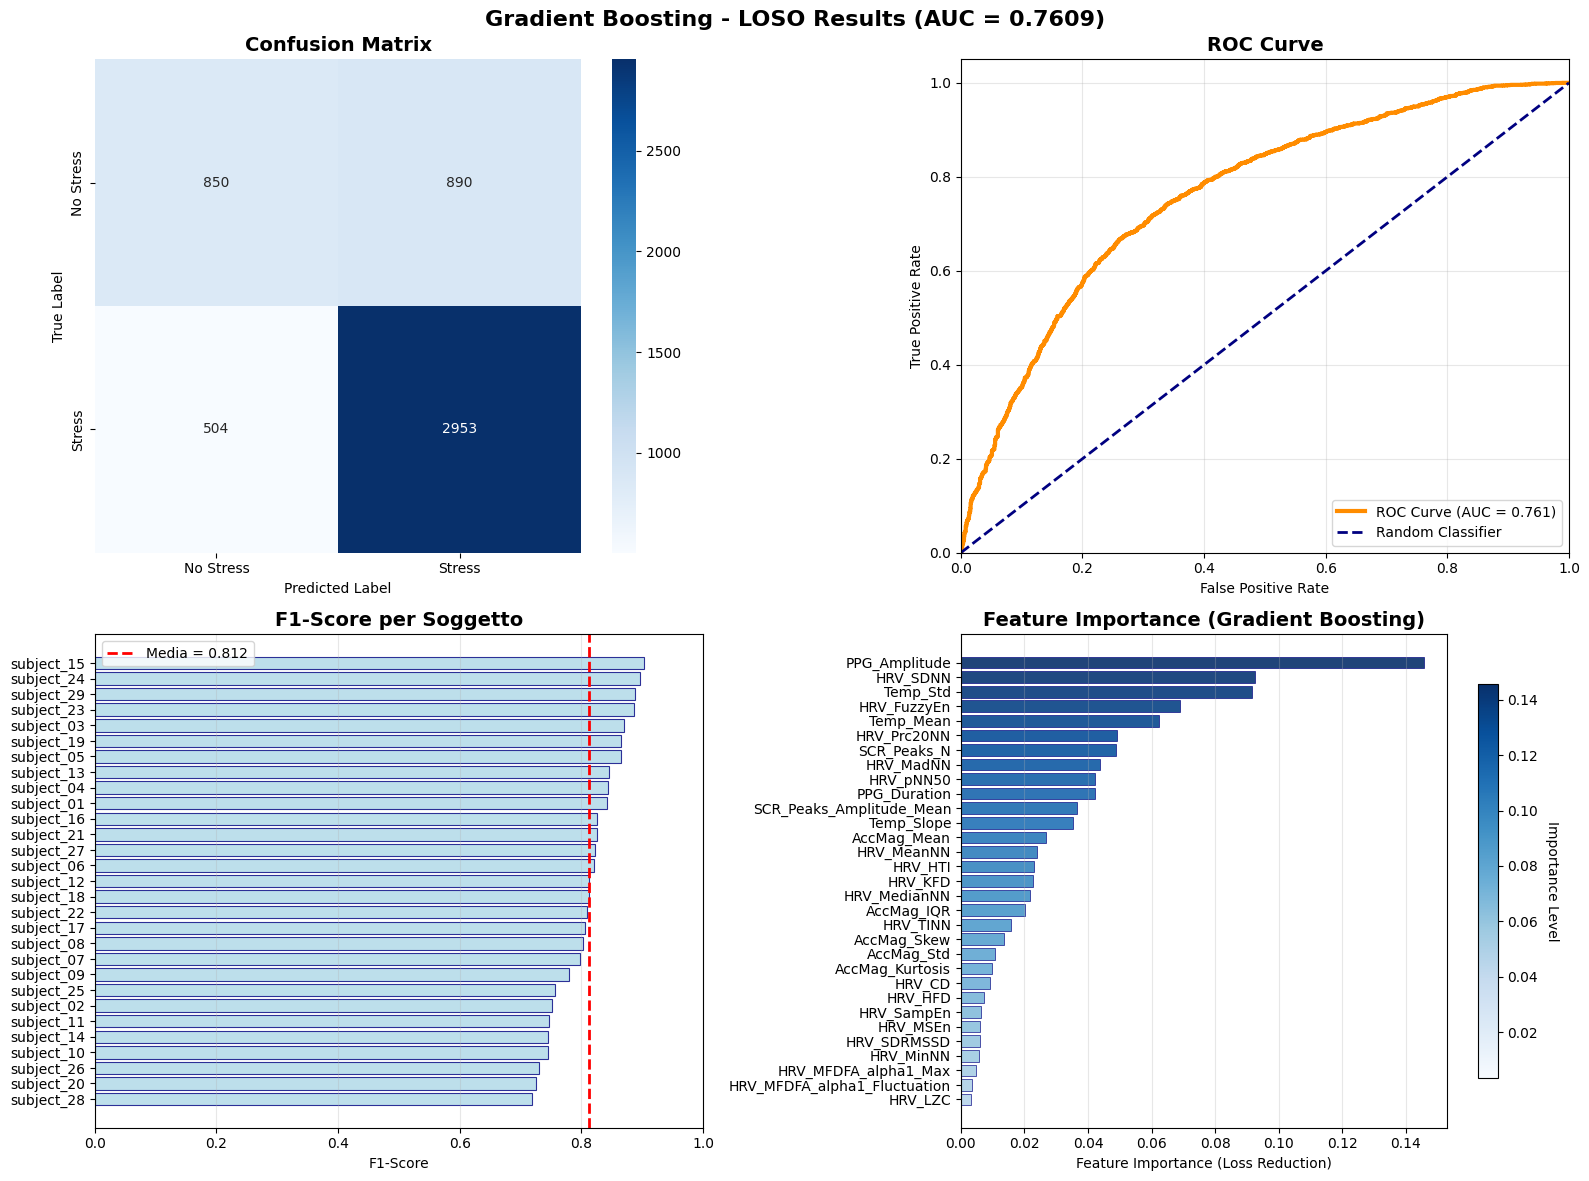


SUMMARY GRADIENT BOOSTING LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8118 ± 0.0547
AUC globale: 0.7609
Accuratezza globale: 0.7318
Range F1-Score: 0.7181 - 0.9030
Miglior soggetto: subject_15 (F1=0.9030)
Peggiore soggetto: subject_28 (F1=0.7181)

Parametri Gradient Boosting:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
N. estimatori effettivi: 100
Training score finale: 0.7764

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 15
  Soggetto test: subject_15
  F1-Score: 0.9030
  Accuracy: 0.8763
  Precision: 0.9554
  Recall: 0.8560


In [ ]:
# =============================================================================
# LOSO GRADIENT BOOSTING CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO GRADIENT BOOSTING ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/GRADIENT_BOOSTING"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (importante per Gradient Boosting)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        max_features='sqrt',
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=1e-4
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "gradient_boosting_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "gradient_boosting_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "gradient_boosting_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (scikit-learn model saved as .pkl)")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Gradient Boosting - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Gradient Boosting Importance
if final_model is not None:
    # Calcola feature importance dal Gradient Boosting
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Loss Reduction)')
    axes[1,1].set_title('Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY GRADIENT BOOSTING LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Gradient Boosting:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"N. estimatori effettivi: {final_model.n_estimators_}")

    # Informazioni training
    if hasattr(final_model, 'train_score_'):
        print(f"Training score finale: {final_model.train_score_[-1]:.4f}")
    if hasattr(final_model, 'validation_scores_'):
        print(f"Validation score finale: {final_model.validation_scores_[-1]:.4f}")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

XGB CLASSIFIER

=== LOSO XGBOOST ===
Samples: 5197, Features: 31, Subjects: 29

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - subject_01: F1=0.852 Acc=0.760
 *** NUOVO BEST MODEL (F1=0.8521) ***  Fold  2 - subject_02: F1=0.760 Acc=0.627
  Fold  3 - subject_03: F1=0.861 Acc=0.827
 *** NUOVO BEST MODEL (F1=0.8612) ***  Fold  4 - subject_04: F1=0.829 Acc=0.754
  Fold  5 - subject_05: F1=0.856 Acc=0.815
  Fold  6 - subject_06: F1=0.823 Acc=0.720
  Fold  7 - subject_07: F1=0.794 Acc=0.667
  Fold  8 - subject_08: F1=0.803 Acc=0.686
  Fold  9 - subject_09: F1=0.780 Acc=0.716
  Fold 10 - subject_10: F1=0.748 Acc=0.637
  Fold 11 - subject_11: F1=0.758 Acc=0.746
  Fold 12 - subject_12: F1=0.810 Acc=0.714
  Fold 13 - subject_13: F1=0.836 Acc=0.784
  Fold 14 - subject_14: F1=0.727 Acc=0.648
  Fold 15 - subject_15: F1=0.885 Acc=0.849
 *** NUOVO BEST MODEL (F1=0.8852) ***  Fold 16 - subject_16: F1=0.814 Acc=0.740
  Fold 17 - subject_17: F1=0.815 Acc=0.694
  Fold 18 - subject_18: F1=0.814 Acc=0.716

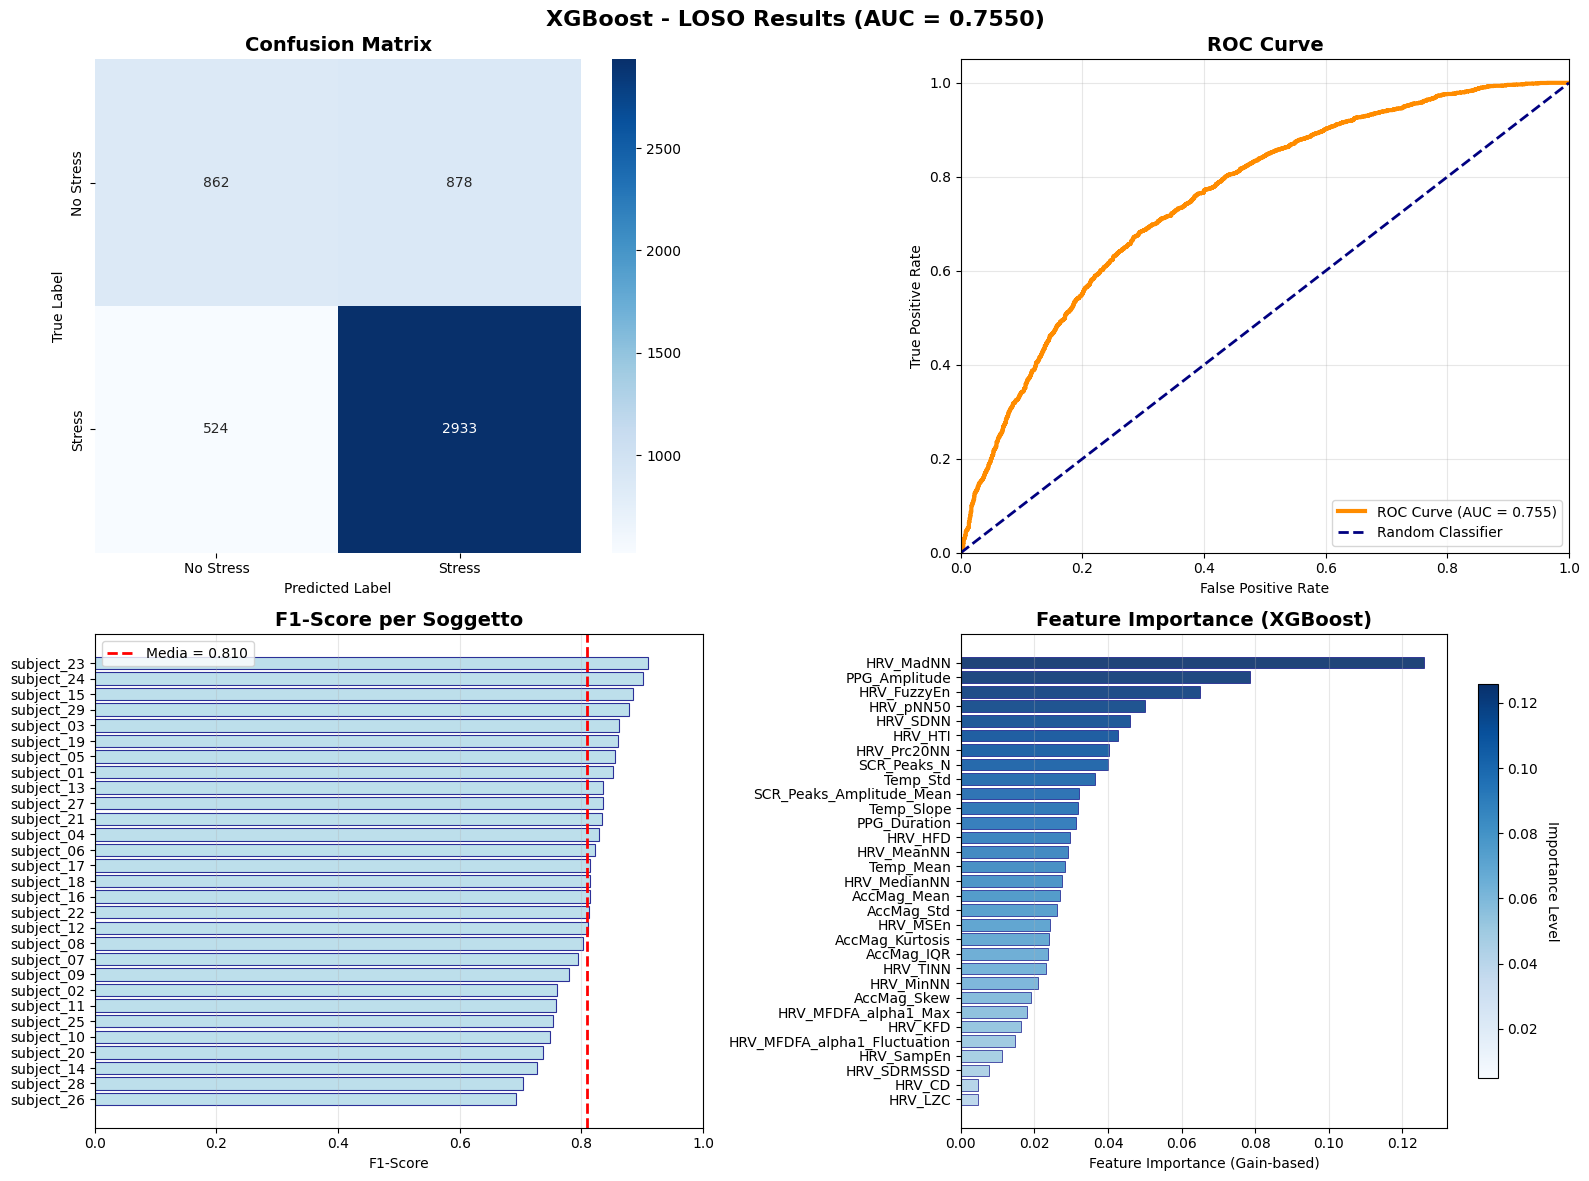


SUMMARY XGBOOST LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8098 ± 0.0570
AUC globale: 0.7550
Accuratezza globale: 0.7302
Range F1-Score: 0.6926 - 0.9091
Miglior soggetto: subject_23 (F1=0.9091)
Peggiore soggetto: subject_26 (F1=0.6926)

Parametri XGBoost:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
Colsample bytree: 0.8
Obiettivo: binary:logistic
Booster: None

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 23
  Soggetto test: subject_23
  F1-Score: 0.9091
  Accuracy: 0.8743
  Precision: 0.8400
  Recall: 0.9906


In [ ]:
# =============================================================================
# LOSO XGBOOST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO XGBOOST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/XGB"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (XGBoost può beneficiare dello scaling)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "xgb_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "xgb_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "xgb_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (XGBoost model saved as .pkl)")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'XGBoost - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - XGBoost Importance
if final_model is not None:
    # XGBoost ha diversi tipi di importance, usiamo 'weight' (numero di split)
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gain-based)')
    axes[1,1].set_title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

    # Informazioni aggiuntive XGBoost specifiche
    try:
        # Prova ad ottenere diversi tipi di importance
        importance_types = ['weight', 'gain', 'cover']
        print(f"\nTipi di importance XGBoost disponibili:")
        booster = final_model.get_booster()
        for imp_type in importance_types:
            try:
                importance_dict = booster.get_score(importance_type=imp_type)
                if importance_dict:
                    max_feature = max(importance_dict, key=importance_dict.get)
                    print(f"  {imp_type}: {max_feature} = {importance_dict[max_feature]:.4f}")
            except:
                continue
    except:
        pass

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY XGBOOST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello XGBoost
if final_model is not None:
    print(f"\nParametri XGBoost:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"Colsample bytree: {final_model.colsample_bytree}")

    # Informazioni training specifiche XGBoost
    try:
        print(f"Obiettivo: {final_model.objective}")
        print(f"Booster: {final_model.booster}")
    except:
        pass

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

SVM CLASSIFIER

=== LOSO SVM ===
Samples: 5197, Features: 31, Subjects: 29

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - subject_01: F1=0.775 Acc=0.673
 *** NUOVO BEST MODEL (F1=0.7748) ***  Fold  2 - subject_02: F1=0.681 Acc=0.544
  Fold  3 - subject_03: F1=0.780 Acc=0.762
 *** NUOVO BEST MODEL (F1=0.7802) ***  Fold  4 - subject_04: F1=0.787 Acc=0.725
 *** NUOVO BEST MODEL (F1=0.7873) ***  Fold  5 - subject_05: F1=0.859 Acc=0.832
 *** NUOVO BEST MODEL (F1=0.8585) ***  Fold  6 - subject_06: F1=0.865 Acc=0.800
 *** NUOVO BEST MODEL (F1=0.8649) ***  Fold  7 - subject_07: F1=0.787 Acc=0.655
  Fold  8 - subject_08: F1=0.780 Acc=0.665
  Fold  9 - subject_09: F1=0.787 Acc=0.754
  Fold 10 - subject_10: F1=0.791 Acc=0.681
  Fold 11 - subject_11: F1=0.823 Acc=0.803
  Fold 12 - subject_12: F1=0.767 Acc=0.676
  Fold 13 - subject_13: F1=0.800 Acc=0.756
  Fold 14 - subject_14: F1=0.760 Acc=0.695
  Fold 15 - subject_15: F1=0.798 Acc=0.769
  Fold 16 - subject_16: F1=0.815 Acc=0.734
  Fold 17 - sub

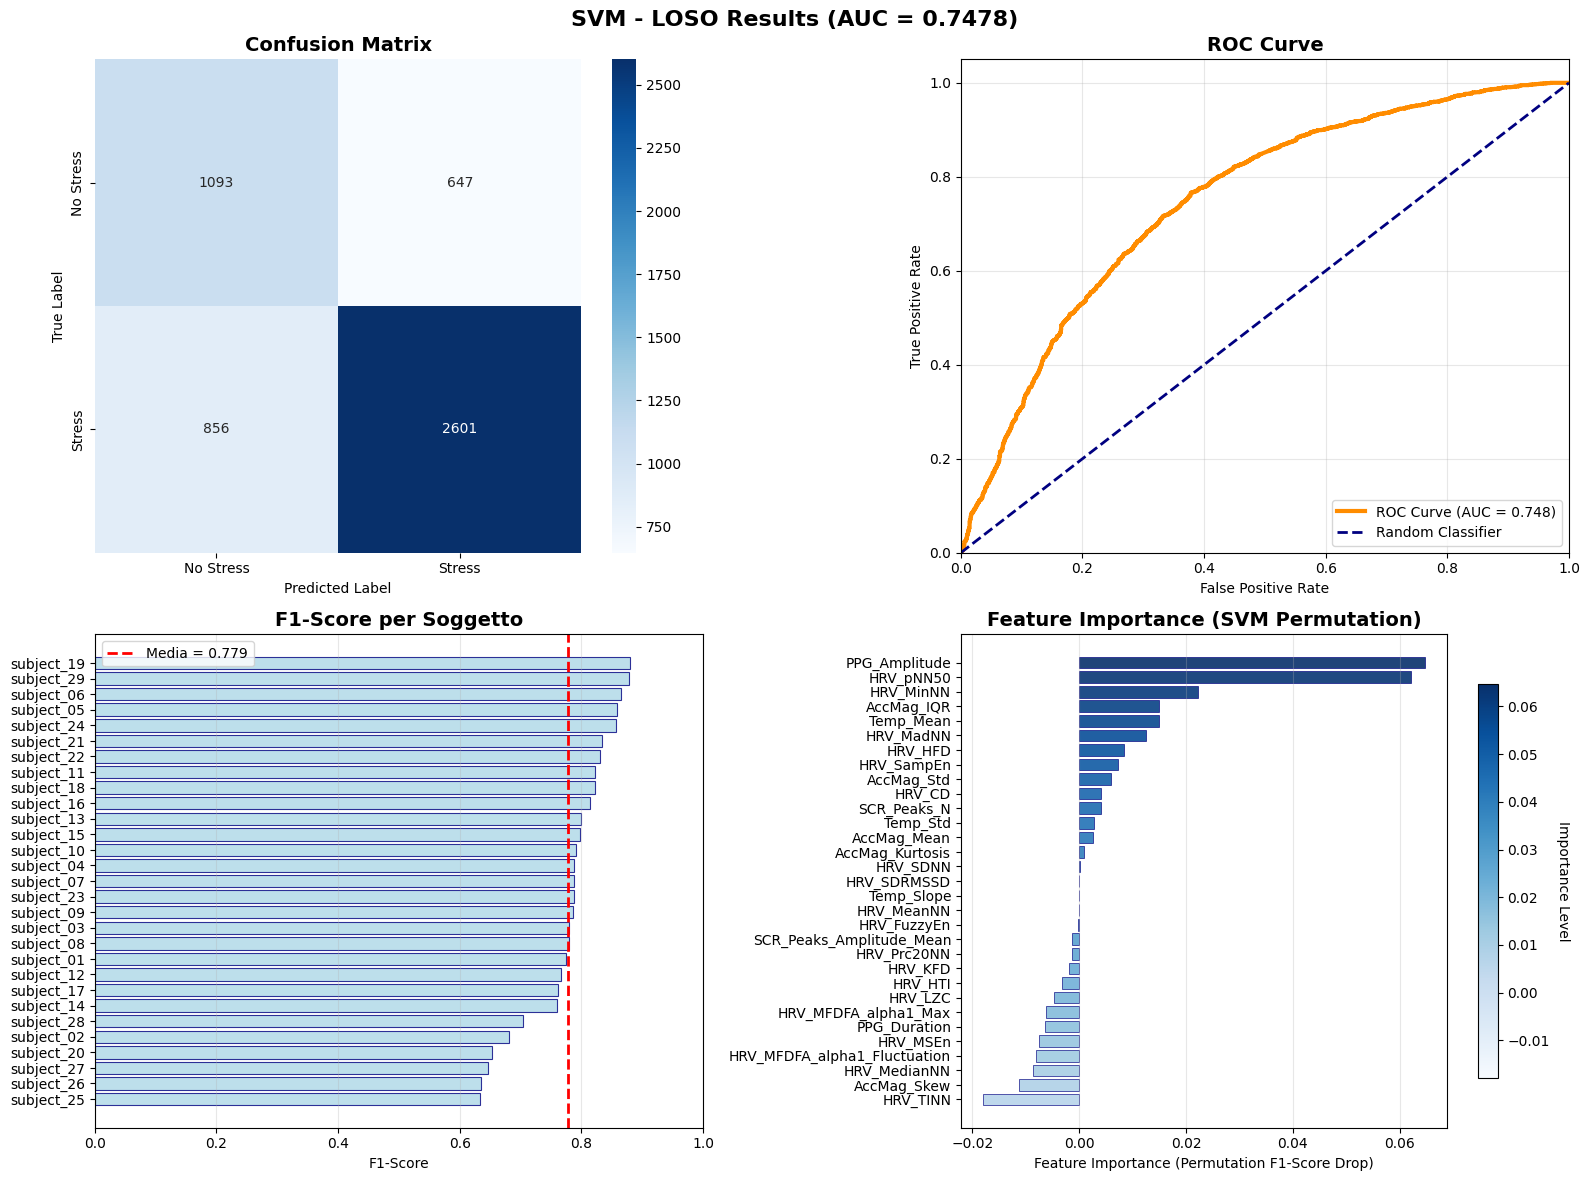


SUMMARY SVM LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.7786 ± 0.0715
AUC globale: 0.7478
Accuratezza globale: 0.7108
Range F1-Score: 0.6339 - 0.8803
Miglior soggetto: subject_19 (F1=0.8803)
Peggiore soggetto: subject_25 (F1=0.6339)

Parametri SVM:
Kernel: rbf
C (regularization): 1.0
Gamma: scale
Class weight: balanced
N. support vectors: [1189 2320]
N. support vectors per classe: {np.int64(0): np.int32(1189), np.int64(1): np.int32(2320)}
Ratio support vectors: 4033.33%

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 19
  Soggetto test: subject_19
  F1-Score: 0.8803
  Accuracy: 0.8372
  Precision: 0.8374
  Recall: 0.9279


In [ ]:
# =============================================================================
# LOSO SVM CON VISUALIZZAZIONI COMPLETE E SALVATAGGIO BEST MODEL
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO SVM ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None
final_X_test = None  # Per calcolo permutation importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/SVM"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per SVM)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Necessario per predict_proba
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model and test data for feature importance
    final_model = model
    final_X_test = X_test_scaled
    final_y_test = y_test

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "svm_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "svm_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "svm_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (SVM model saved as .pkl)")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'SVM - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - SVM Permutation Importance
if final_model is not None and final_X_test is not None:
    print("Calcolo permutation importance per SVM...")

    try:
        # Calcola permutation importance (unico metodo disponibile per SVM)
        perm_importance = permutation_importance(
            final_model, final_X_test, final_y_test,
            n_repeats=10, random_state=42, scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza (palette blu scura)
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (SVM Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed',
                       ha='center', va='center', fontsize=12,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY SVM LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello SVM
if final_model is not None:
    print(f"\nParametri SVM:")
    print(f"Kernel: {final_model.kernel}")
    print(f"C (regularization): {final_model.C}")
    print(f"Gamma: {final_model.gamma}")
    print(f"Class weight: {final_model.class_weight}")

    # Informazioni sui support vectors
    print(f"N. support vectors: {final_model.n_support_}")
    print(f"N. support vectors per classe: {dict(zip(final_model.classes_, final_model.n_support_))}")
    if final_X_test is not None:
        support_vector_ratio = final_model.support_vectors_.shape[0] / len(final_X_test)
        print(f"Ratio support vectors: {support_vector_ratio:.2%}")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

MLP

=== LOSO MLP ===
Samples: 5197, Features: 31, Subjects: 29

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - subject_01: F1=0.810 Acc=0.697 (9ep)
 *** NUOVO BEST MODEL (F1=0.8097) ***
  Fold  2 - subject_02: F1=0.805 Acc=0.674 (6ep)

  Fold  3 - subject_03: 

F1=0.860 Acc=0.827 (20ep)
 *** NUOVO BEST MODEL (F1=0.8599) ***
  Fold  4 - subject_04: 

F1=0.800 Acc=0.731 (15ep)

  Fold  5 - subject_05: F1=0.868 Acc=0.838 (12ep)
 *** NUOVO BEST MODEL (F1=0.8679) ***
  Fold  6 - subject_06: F1=0.848 Acc=0.766 (11ep)

  Fold  7 - subject_07: F1=0.783 Acc=0.644 (7ep)

  Fold  8 - subject_08: F1=0.789 Acc=0.676 (8ep)

  Fold  9 - subject_09: F1=0.825 Acc=0.781 (9ep)

  Fold 10 - subject_10: F1=0.797 Acc=0.692 (10ep)

  Fold 11 - subject_11: F1=0.951 Acc=0.936 (11ep)
 *** NUOVO BEST MODEL (F1=0.9507) ***
  Fold 12 - subject_12: F1=0.806 Acc=0.714 (12ep)

  Fold 13 - subject_13: F1=0.825 Acc=0.761 (10ep)

  Fold 14 - subject_14: F1=0.797 Acc=0.723 (9ep)

  Fold 15 - subject_15: F1=0.899 Acc=0.866 (10ep)

  Fold 16 - subject_16: F1=0.809 Acc=0.704 (12ep)

  Fold 17 - subject_17: F1=0.815 Acc=0.689 (7ep)

  Fold 18 - subject_18: F1=0.820 Acc=0.746 (11ep)

  Fold 19 - subject_19: F1=0.871 Acc=0.814 (9ep)

  Fold 20 - subject_20: F1=0.797 Acc=0.688 (6ep)

  Fold 21 - subject_21: F1=0.815 Acc=0.750 (13ep)

  Fold 22 - subject_22: F1=0.831 Acc=0.

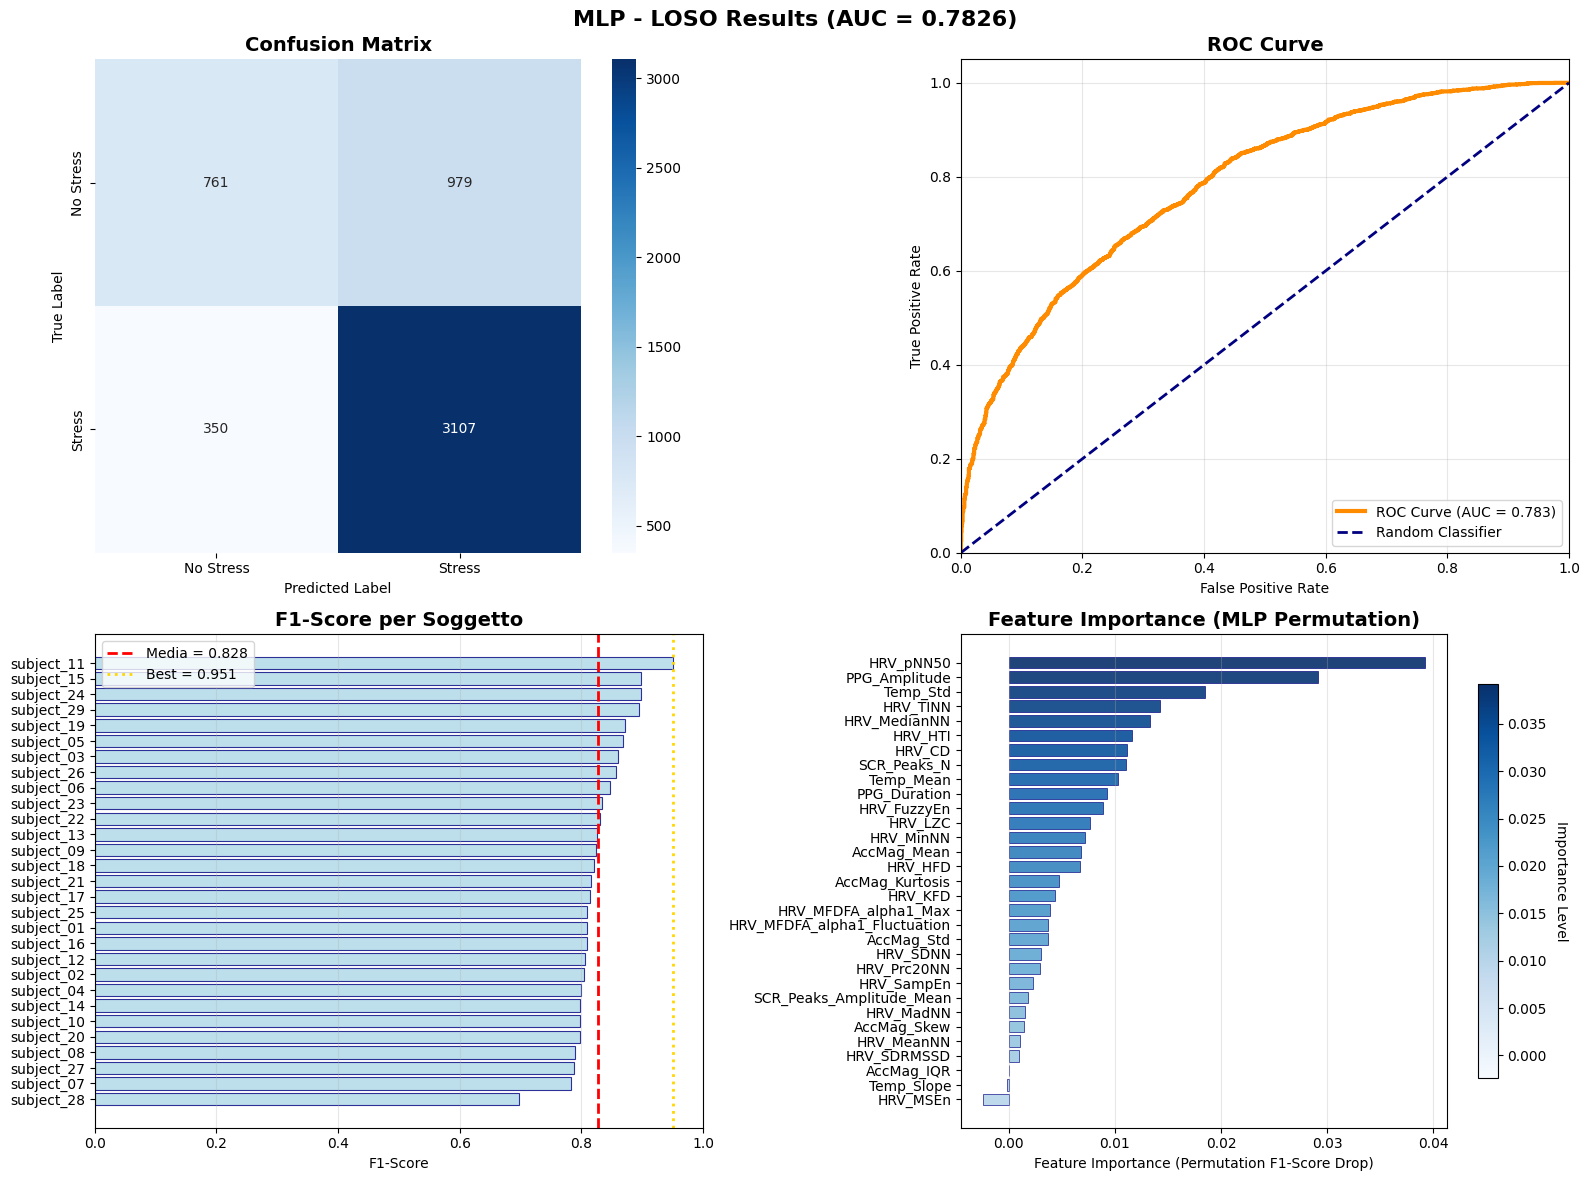


SUMMARY MLP LOSO
Dataset: 29 soggetti, 5197 campioni totali
F1-Score medio: 0.8276 ± 0.0477
AUC globale: 0.7826
Accuratezza globale: 0.7443
Range F1-Score: 0.6969 - 0.9507
Miglior soggetto: subject_11 (F1=0.9507)
Peggiore soggetto: subject_28 (F1=0.6969)
Epoche medie utilizzate: 10.4
Early stopping attivato: 29 / 29 fold

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 11
  Soggetto test: subject_11
  F1-Score: 0.9507
  Accuracy: 0.9364
  Epoche utilizzate: 11


In [ ]:
# =============================================================================
# LOSO MLP CON SALVATAGGIO BEST MODEL E VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE MODELLO MLP
# =============================================================================

def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))

    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject", "protocol_phase"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/MLP"
os.makedirs(save_dir, exist_ok=True)

print("=== LOSO MLP ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per reti neurali)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Costruisci modello
    model = build_mlp_model(X_train_scaled.shape[1])

    # Callback per early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_prob = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    epochs_used = len(history.history['loss'])
    print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep)")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'epochs_used': epochs_used
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = tf.keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())
        best_scaler = scaler
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'epochs_used': epochs_used
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    print()  # New line

    # Pulizia memoria
    del model, history
    tf.keras.backend.clear_session()

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    model_path = os.path.join(save_dir, "mlp_best_loso_model.keras")
    best_model.save(model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "mlp_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "mlp_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path}")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
print(f"Epoche medie:    {results_df['epochs_used'].mean():.1f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'MLP - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')

# Evidenzia miglior fold
best_fold = results_df.loc[results_df['f1_score'].idxmax()]
axes[1,0].axvline(x=best_fold['f1_score'], color='gold', linestyle=':', linewidth=2,
                  label=f'Best = {best_fold["f1_score"]:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - MLP Permutation Importance
if best_model is not None:
    print("Calcolo permutation importance per MLP...")

    try:
        # Prepara dati per permutation importance usando miglior modello
        # Usa un subset rappresentativo per velocità
        sample_size = min(500, len(all_y_true))
        sample_indices = np.random.choice(len(all_y_true), sample_size, replace=False)

        X_sample = np.array([X[i] for i in sample_indices])
        y_sample = np.array([all_y_true[i] for i in sample_indices])

        # Normalizza con best_scaler
        X_sample_scaled = best_scaler.transform(X_sample)

        # Wrapper class per sklearn compatibility
        class MLPWrapper:
            def __init__(self, model):
                self.model = model

            def fit(self, X, y):
                return self  # Dummy fit

            def predict(self, X):
                return (self.model.predict(X, verbose=0) > 0.5).astype(int).flatten()

            def score(self, X, y):
                y_pred = self.predict(X)
                return f1_score(y, y_pred, zero_division=0)

        # Crea wrapper
        mlp_wrapper = MLPWrapper(best_model)

        # Calcola permutation importance
        perm_importance = permutation_importance(
            mlp_wrapper, X_sample_scaled, y_sample,
            n_repeats=5,  # Ridotto per velocità
            random_state=42,
            scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (MLP Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed\n(Computationally expensive)',
                       ha='center', va='center', fontsize=11,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY MLP LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject_result = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject_result = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject_result} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject_result} (F1={results_df['f1_score'].min():.4f})")

# Informazioni training
print(f"Epoche medie utilizzate: {results_df['epochs_used'].mean():.1f}")
print(f"Early stopping attivato: {np.sum(results_df['epochs_used'] < 30)} / {len(results_df)} fold")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Epoche utilizzate: {best_model_info['epochs_used']}")

print(f"{'='*60}")

CROSS TEST AND TRANSFER LEARNING

WESAD --> CAMPANELLA

CROSS TEST

In [ ]:
# =============================================================================
# CARICAMENTO MIGLIORI MODELLI WESAD E RELATIVI SCALER
# =============================================================================

import joblib
import json
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE FUNZIONI DI CARICAMENTO
# =============================================================================

def load_sklearn_model(model_dir, model_name):
    """Carica modello sklearn, scaler (opzionale) e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.pkl")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento modello (obbligatorio)
        model = joblib.load(model_path)

        # Caricamento scaler (opzionale per tree-based models)
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            scaling_required = True
        else:
            scaler = None
            scaling_required = False
            print(f"  ⚠️  {model_name.upper()}: Scaler non trovato - Tree-based model, scaling non necessario")

        # Caricamento info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

def load_keras_model(model_dir, model_name):
    """Carica modello Keras, scaler e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.keras")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

# =============================================================================
# CARICAMENTO MODELLI WESAD
# =============================================================================

print("="*60)
print("CARICAMENTO MIGLIORI MODELLI WESAD")
print("="*60)

base_dir = "/content/drive/MyDrive/BEST_MODELS/WESAD"

# Dizionario per memorizzare tutti i modelli
wesad_models = {}

# Modelli sklearn
sklearn_models = ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting']
for model_name in sklearn_models:
    model_dir = os.path.join(base_dir, model_name.upper())
    if os.path.exists(model_dir):
        model, scaler, info = load_sklearn_model(model_dir, model_name)
        if model is not None:
            wesad_models[model_name] = {
                'model': model,
                'scaler': scaler,
                'info': info,
                'type': 'sklearn'
            }

# Modello MLP (Keras)
mlp_dir = os.path.join(base_dir, "MLP")
if os.path.exists(mlp_dir):
    model, scaler, info = load_keras_model(mlp_dir, "mlp")
    if model is not None:
        wesad_models['mlp'] = {
            'model': model,
            'scaler': scaler,
            'info': info,
            'type': 'keras'
        }

print(f"\n✓ Totale modelli caricati: {len(wesad_models)}")
print("Modelli disponibili:", list(wesad_models.keys()))

# =============================================================================
# VERIFICA FEATURE COMPATIBILITY
# =============================================================================

print(f"\n{'-'*50}")
print("VERIFICA COMPATIBILITÀ FEATURE")
print(f"{'-'*50}")

# Verifica che le feature del dataset CAMPANELLA siano compatibili con WESAD
campanella_features = df.drop(columns=['label', 'subject', 'protocol_phase']).columns
n_campanella_features = len(campanella_features)

print(f"Features CAMPANELLA: {n_campanella_features}")

for model_name, model_data in wesad_models.items():
    try:
        if model_data['type'] == 'sklearn':
            # Per modelli sklearn, verifica n_features_in_
            expected_features = model_data['model'].n_features_in_
        elif model_data['type'] == 'keras':
            # Per modelli Keras, verifica input_shape
            expected_features = model_data['model'].input_shape[1]

        if expected_features == n_campanella_features:
            print(f"✓ {model_name.upper()}: Compatible ({expected_features} features)")
        else:
            print(f"✗ {model_name.upper()}: Incompatible - Expected: {expected_features}, Got: {n_campanella_features}")

    except Exception as e:
        print(f"✗ {model_name.upper()}: Error checking compatibility - {e}")

print(f"\n{'-'*50}")
print("MODELLI PRONTI PER CROSS-TEST")
print(f"{'-'*50}")

CARICAMENTO MIGLIORI MODELLI WESAD
✓ SVM caricato - F1: 0.9821, Soggetto: S4
✓ XGB caricato - F1: 0.9821, Soggetto: S4
✓ LOGISTIC_REGRESSION caricato - F1: 0.9821, Soggetto: S4
  ⚠️  RANDOM_FOREST: Scaler non trovato - Tree-based model, scaling non necessario
✓ RANDOM_FOREST caricato - F1: 0.9630, Soggetto: S4
✓ GRADIENT_BOOSTING caricato - F1: 0.9825, Soggetto: S4
✓ MLP caricato - F1: 0.9821, Soggetto: S4

✓ Totale modelli caricati: 6
Modelli disponibili: ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting', 'mlp']

--------------------------------------------------
VERIFICA COMPATIBILITÀ FEATURE
--------------------------------------------------
Features CAMPANELLA: 31
✓ SVM: Compatible (31 features)
✓ XGB: Compatible (31 features)
✓ LOGISTIC_REGRESSION: Compatible (31 features)
✓ RANDOM_FOREST: Compatible (31 features)
✓ GRADIENT_BOOSTING: Compatible (31 features)
✓ MLP: Compatible (31 features)

--------------------------------------------------
MODELLI PRONTI

CROSS TEST: MODELLI WESAD → DATASET CAMPANELLA
Dataset CAMPANELLA: 5197 campioni, 31 features, 29 soggetti

⚠️  SKIPPING SVM - Noto per fallimento cross-dataset

------------------------------------------------------------
CROSS-TEST: XGB
Original F1-Score WESAD: 0.9821
------------------------------------------------------------
Valutazione LOSO:
  Fold  1 - subject_01: F1=0.828 Acc=0.726
  Fold  2 - subject_02: F1=0.485 Acc=0.451
  Fold  3 - subject_03: F1=0.549 Acc=0.589
  Fold  4 - subject_04: F1=0.194 Acc=0.415
  Fold  5 - subject_05: F1=0.394 Acc=0.503
  Fold  6 - subject_06: F1=0.647 Acc=0.514
  Fold  7 - subject_07: F1=0.603 Acc=0.569
  Fold  8 - subject_08: F1=0.642 Acc=0.535
  Fold  9 - subject_09: F1=0.536 Acc=0.574
  Fold 10 - subject_10: F1=0.582 Acc=0.549
  Fold 11 - subject_11: F1=0.589 Acc=0.509
  Fold 12 - subject_12: F1=0.639 Acc=0.566
  Fold 13 - subject_13: F1=0.558 Acc=0.585
  Fold 14 - subject_14: F1=0.661 Acc=0.596
  Fold 15 - subject_15: F1=0.404 Acc=0.414
  Fol

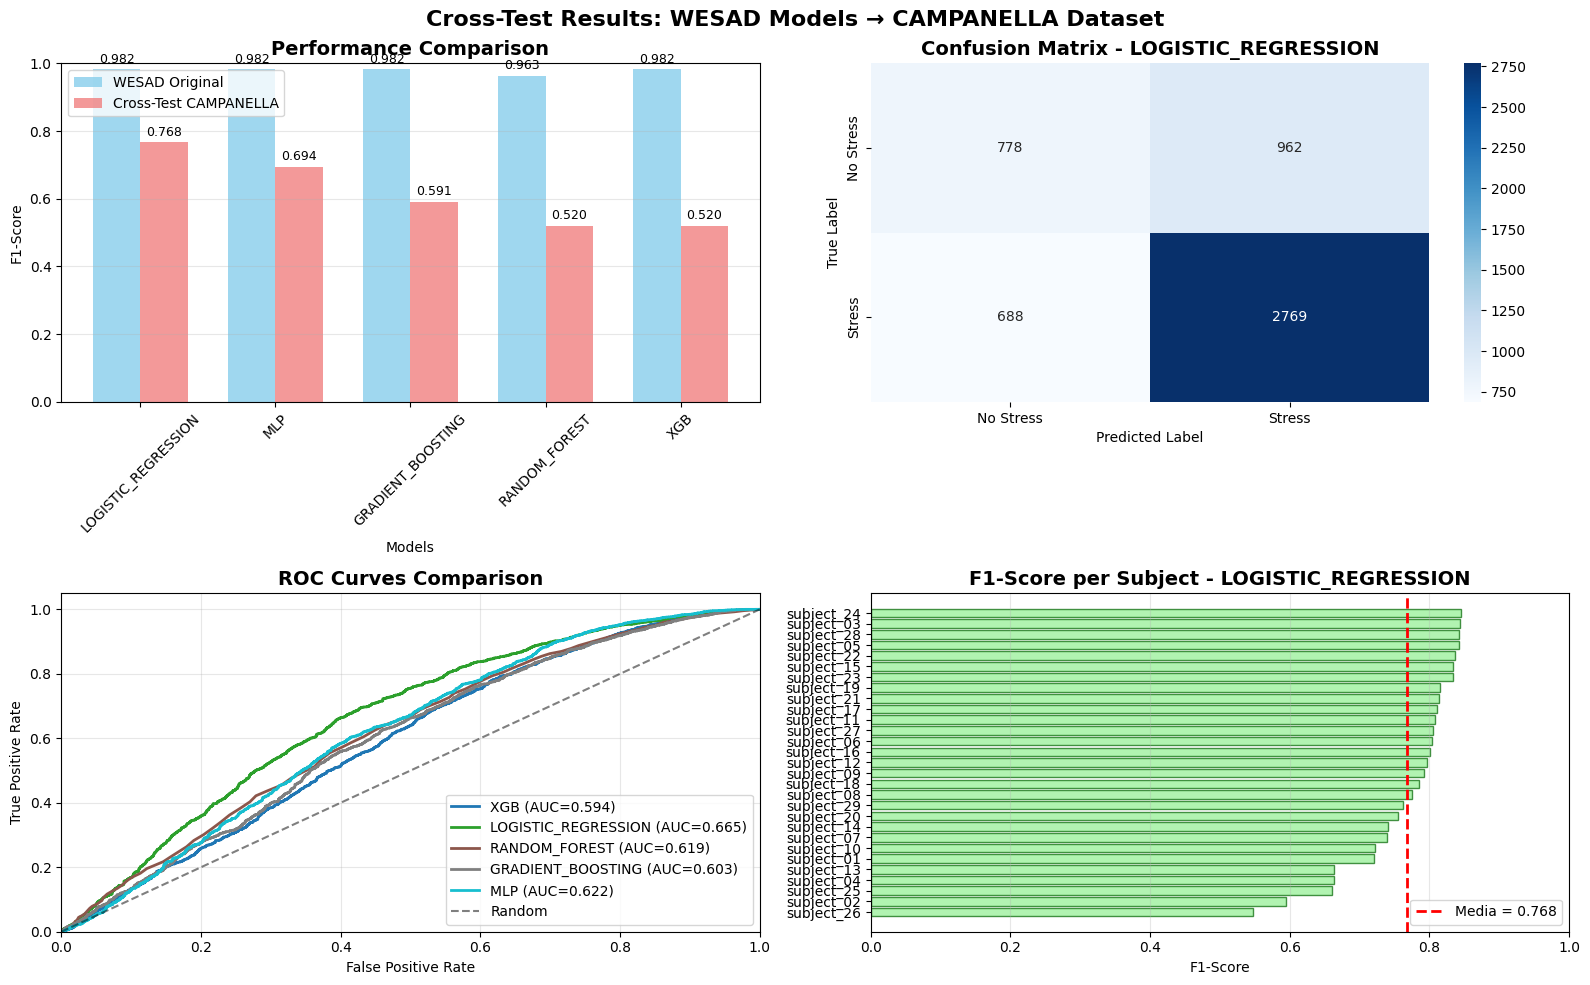


------------------------------------------------------------
ANALISI DISTRIBUZIONE PREDIZIONI
------------------------------------------------------------

XGB:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=58.80%, Stress=41.20%
  Campioni totali: 5197 (No-Stress: 3056, Stress: 2141)

LOGISTIC_REGRESSION:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=28.21%, Stress=71.79%
  Campioni totali: 5197 (No-Stress: 1466, Stress: 3731)

RANDOM_FOREST:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=62.61%, Stress=37.39%
  Campioni totali: 5197 (No-Stress: 3254, Stress: 1943)

GRADIENT_BOOSTING:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=52.57%, Stress=47.43%
  Campioni totali: 5197 (No-Stress: 2732, Stress: 2465)

MLP:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No

In [ ]:
# =============================================================================
# CROSS TEST: MODELLI WESAD → DATASET CAMPANELLA CON SOGLIA FISSA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI CAMPANELLA PER CROSS-TEST
# =============================================================================

# Prepara dati CAMPANELLA
X_campanella = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y_campanella = df['label'].values
groups_campanella = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print("="*70)
print("CROSS TEST: MODELLI WESAD → DATASET CAMPANELLA")
print("="*70)
print(f"Dataset CAMPANELLA: {len(X_campanella)} campioni, {X_campanella.shape[1]} features, {len(np.unique(groups_campanella))} soggetti")

# =============================================================================
# FUNZIONE PER CROSS-TEST CON CALIBRAZIONE SOGLIE
# =============================================================================

# =============================================================================
# FUNZIONE PER CROSS-TEST CON SOGLIA FISSA
# =============================================================================

def cross_test_model(model_name, model_data, X, y, groups, logo):
    """Esegue cross-test di un singolo modello con LOSO"""

    print(f"\n{'-'*60}")
    print(f"CROSS-TEST: {model_name.upper()}")
    print(f"Original F1-Score WESAD: {model_data['info']['f1_score']:.4f}")
    print(f"{'-'*60}")

    model = model_data['model']
    scaler = model_data['scaler']
    model_type = model_data['type']

    # Risultati per questo modello
    fold_results = []
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    print("Valutazione LOSO:")

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        subject = groups[test_idx[0]]
        print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

        # Dati di test
        X_test = X[test_idx]
        y_test = y[test_idx]

        # Skip se una sola classe nel test set
        if len(np.unique(y_test)) < 2:
            print("SKIP (una sola classe)")
            continue

        # Scaling con scaler WESAD (senza refit!) - opzionale per tree-based models
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            # Per modelli tree-based che non richiedono scaling
            X_test_scaled = X_test

        try:
            # Predizione in base al tipo di modello con SOGLIA FISSA 0.5
            if model_type == 'sklearn':
                y_pred = model.predict(X_test_scaled)

                # Probabilità se disponibili
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_test_scaled)[:, 1]
                elif hasattr(model, 'decision_function'):
                    # Per SVM senza probability=True
                    decision_scores = model.decision_function(X_test_scaled)
                    # Normalizza tra 0 e 1 usando sigmoid
                    y_prob = 1 / (1 + np.exp(-decision_scores))
                else:
                    y_prob = y_pred.astype(float)  # Fallback

            elif model_type == 'keras':
                y_prob = model.predict(X_test_scaled, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA 0.5

            # Calcola metriche
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"F1={f1:.3f} Acc={acc:.3f}")

            # Salva risultati
            fold_results.append({
                'fold': fold + 1,
                'subject': subject,
                'n_samples': len(y_test),
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

            # Accumula per metriche globali
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

        except Exception as e:
            print(f"ERROR: {e}")
            continue

    # Calcola statistiche aggregate e mostra classification report
    if fold_results:
        results_df = pd.DataFrame(fold_results)

        print(f"\nRisultati {model_name.upper()}:")
        print(f"  F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
        print(f"  Accuracy media: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")

        # CLASSIFICATION REPORT GLOBALE per questo modello
        print(f"\nClassification Report Globale - {model_name.upper()}:")
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))

        # Performance drop rispetto a WESAD
        performance_drop = model_data['info']['f1_score'] - results_df['f1_score'].mean()
        print(f"  Performance drop: {performance_drop:+.4f}")

        return {
            'model_name': model_name,
            'fold_results': fold_results,
            'results_df': results_df,
            'all_y_true': np.array(all_y_true),
            'all_y_pred': np.array(all_y_pred),
            'all_y_prob': np.array(all_y_prob),
            'original_f1': model_data['info']['f1_score'],
            'cross_test_f1': results_df['f1_score'].mean(),
            'performance_drop': performance_drop
        }
    else:
        print(f"Nessun risultato per {model_name}")
        return None

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

for model_name, model_data in wesad_models.items():
    if model_name in excluded_models:
        print(f"\n⚠️  SKIPPING {model_name.upper()} - Noto per fallimento cross-dataset")
        continue

    try:
        result = cross_test_model(model_name, model_data, X_campanella, y_campanella, groups_campanella, logo)
        if result is not None:
            cross_test_results[model_name] = result
    except Exception as e:
        print(f"Errore generale cross-test {model_name}: {e}")
        continue

# =============================================================================
# ANALISI COMPARATIVA E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if cross_test_results:
    print(f"\n{'='*70}")
    print("ANALISI COMPARATIVA CROSS-TEST")
    print(f"{'='*70}")

    # Crea tabella comparativa
    comparison_data = []
    for model_name, result in cross_test_results.items():
        comparison_data.append({
            'Model': model_name.upper(),
            'WESAD_F1': result['original_f1'],
            'CrossTest_F1': result['cross_test_f1'],
            'Performance_Drop': result['performance_drop'],
            'N_Subjects': len(result['results_df'])
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('CrossTest_F1', ascending=False)

    print("Tabella Comparativa Performance:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    # Trova miglior modello cross-test
    best_model_name = comparison_df.iloc[0]['Model'].lower()
    best_result = cross_test_results[best_model_name]

    print(f"\nMiglior modello cross-test: {best_model_name.upper()}")
    print(f"F1-Score cross-test: {best_result['cross_test_f1']:.4f}")
    print(f"Performance drop: {best_result['performance_drop']:+.4f}")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (2x2 GRID)
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*50}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cross-Test Results: WESAD Models → CAMPANELLA Dataset',
                 fontsize=16, fontweight='bold')

    # 1. COMPARISON BAR CHART (Top Left)
    models = comparison_df['Model']
    wesad_scores = comparison_df['WESAD_F1']
    crosstest_scores = comparison_df['CrossTest_F1']

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[0,0].bar(x - width/2, wesad_scores, width, label='WESAD Original',
                         color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, crosstest_scores, width, label='Cross-Test CAMPANELLA',
                         color='lightcoral', alpha=0.8)

    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('F1-Score')
    axes[0,0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    axes[0,0].set_ylim(0, 1)

    # Aggiungi valori sulle barre
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        axes[0,0].text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                      f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0,0].text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                      f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. CONFUSION MATRIX del miglior modello (Top Right)
    best_y_true = best_result['all_y_true']
    best_y_pred = best_result['all_y_pred']
    best_cm = confusion_matrix(best_y_true, best_y_pred)

    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')

    # 3. ROC CURVES COMPARATIVE (Bottom Left)
    colors_roc = plt.cm.tab10(np.linspace(0, 1, len(cross_test_results)))

    for i, (model_name, result) in enumerate(cross_test_results.items()):
        if len(result['all_y_true']) > 0:
            fpr, tpr, _ = roc_curve(result['all_y_true'], result['all_y_prob'])
            roc_auc_model = auc(fpr, tpr)

            axes[1,0].plot(fpr, tpr, color=colors_roc[i], lw=2,
                          label=f'{model_name.upper()} (AUC={roc_auc_model:.3f})')

    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. F1-SCORE DISTRIBUTION per miglior modello (Bottom Right)
    best_df = best_result['results_df'].sort_values('f1_score', ascending=True)

    bars = axes[1,1].barh(best_df['subject'], best_df['f1_score'],
                         color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1,1].set_xlabel('F1-Score')
    axes[1,1].set_title(f'F1-Score per Subject - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Linea media
    mean_f1 = best_df['f1_score'].mean()
    axes[1,1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                     label=f'Media = {mean_f1:.3f}')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Mostra analisi bilanciamento per ogni modello
    print(f"\n{'-'*60}")
    print("ANALISI DISTRIBUZIONE PREDIZIONI")
    print(f"{'-'*60}")

    for model_name, result in cross_test_results.items():
        y_true = result['all_y_true']
        y_pred = result['all_y_pred']

        # Distribuzione reale
        true_counts = np.bincount(y_true, minlength=2)
        true_ratio = true_counts / len(y_true)

        # Distribuzione predetta
        pred_counts = np.bincount(y_pred, minlength=2)
        pred_ratio = pred_counts / len(y_pred)

        print(f"\n{model_name.upper()}:")
        print(f"  Distribuzione reale:    No-Stress={true_ratio[0]:.2%}, Stress={true_ratio[1]:.2%}")
        print(f"  Distribuzione predetta: No-Stress={pred_ratio[0]:.2%}, Stress={pred_ratio[1]:.2%}")
        print(f"  Campioni totali: {len(y_pred)} (No-Stress: {pred_counts[0]}, Stress: {pred_counts[1]})")

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Directory per salvataggio
    save_dir = "/content/drive/MyDrive/CROSS_TEST_RESULTS/WESAD_TO_CAMPANELLA"
    os.makedirs(save_dir, exist_ok=True)

    # Salva tabella comparativa
    comparison_path = os.path.join(save_dir, "wesad_to_campanella_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)

    # Salva dettagli per ogni modello
    for model_name, result in cross_test_results.items():
        model_path = os.path.join(save_dir, f"{model_name}_detailed_results.csv")
        result['results_df'].to_csv(model_path, index=False)

    # Salva summary JSON
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'CAMPANELLA',
        'method': 'cross_test_fixed_threshold',
        'best_model': best_model_name,
        'best_crosstest_f1': float(best_result['cross_test_f1']),
        'average_performance_drop': float(comparison_df['Performance_Drop'].mean()),
        'models_tested': list(cross_test_results.keys()),
        'excluded_models': excluded_models,
        'n_subjects': len(np.unique(groups_campanella))
    }

    summary_path = os.path.join(save_dir, "cross_test_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in: {save_dir}")
    print(f"  • Comparazione: {comparison_path}")
    print(f"  • Summary: {summary_path}")
    print(f"  • Dettagli per modello: {len(cross_test_results)} file CSV")

else:
    print("Nessun risultato cross-test disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("CROSS-TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING MLP WESAD

✓ MLP WESAD caricato
  F1-Score originale: 0.9821
  Miglior soggetto: S4
  Architettura: 16 layer

TRANSFER LEARNING MLP: WESAD → CAMPANELLA
Dataset CAMPANELLA: 5197 campioni, 31 features, 29 soggetti
Parametri TL: 10 epoche max, LR=0.0001, Batch=16

Inizio Transfer Learning LOSO:
  Fold  1 - subject_01: Frozen layers: 15, Trainable: 1 F1=0.743 Acc=0.620 (10ep)
  Fold  2 - subject_02: Frozen layers: 15, Trainable: 1 F1=0.609 Acc=0.508 (10ep)
  Fold  3 - subject_03: Frozen layers: 15, Trainable: 1 F1=0.831 Acc=0.804 (10ep)
  Fold  4 - subject_04: Frozen layers: 15, Trainable: 1 F1=0.417 Acc=0.509 (10ep)
  Fold  5 - subject_05: Frozen layers: 15, Trainable: 1 F1=0.648 Acc=0.630 (10ep)
  Fold  6 - subject_06: Frozen layers: 15, Trainable: 1 F1=0.799 Acc=0.674 (10ep)
  Fold  7 - subject_07: Frozen layers: 15, Trainable: 1 F1=0.718 Acc=0.603 (10ep)
  Fold  8 - subject_08: Frozen layers: 15, Trainable: 1 F1=0.758 Acc=0.627 (10ep)
  Fold  9 - subject_09: Frozen layers: 15, Trainable: 1 F1=0.6

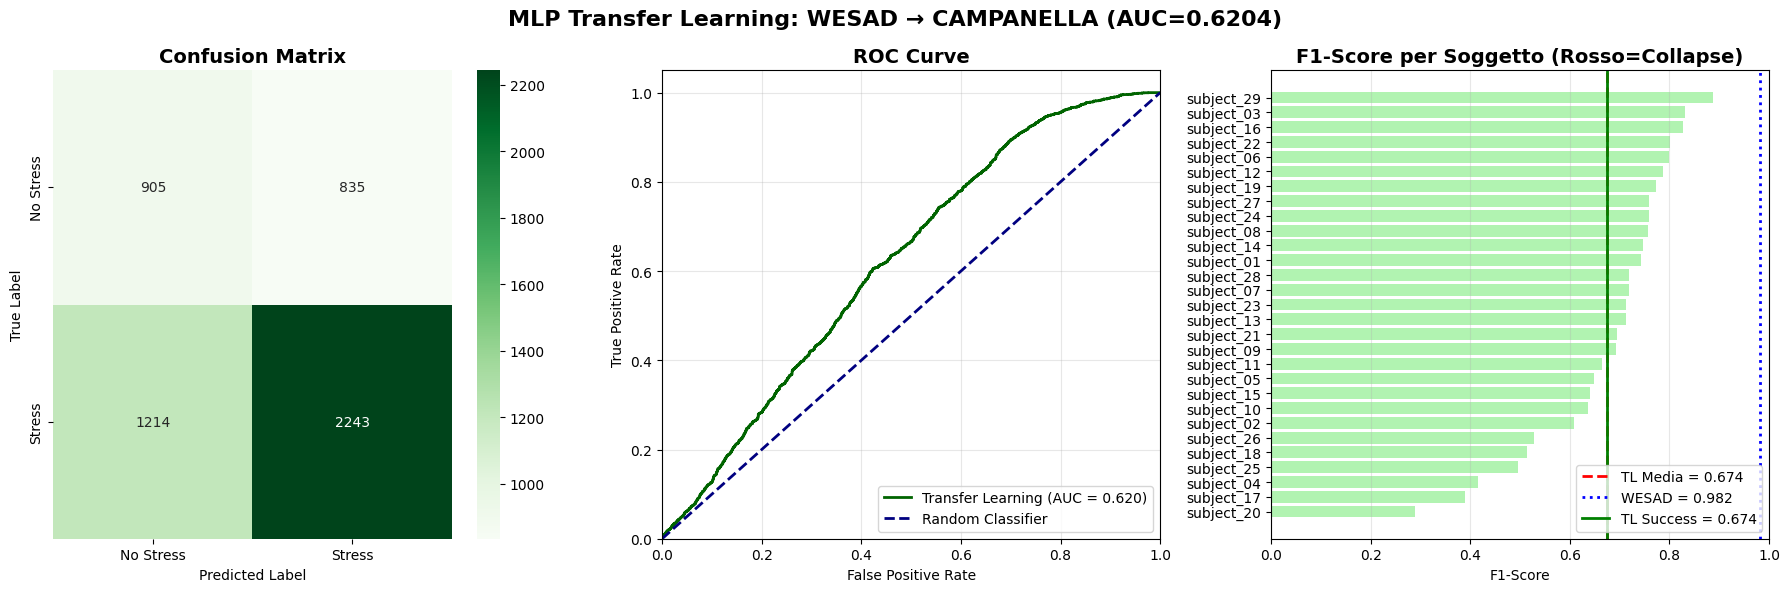


✓ Risultati salvati in:
  • Dettagli: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/WESAD_TO_CAMPANELLA/mlp_transfer_learning_results.csv
  • Summary: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/WESAD_TO_CAMPANELLA/mlp_transfer_learning_summary.json

TRANSFER LEARNING MLP COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING MLP: WESAD → CAMPANELLA (VISUALIZZAZIONI RIDOTTE)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO MLP WESAD
# =============================================================================

def load_wesad_mlp():
    """Carica il miglior modello MLP da WESAD"""
    model_dir = "/content/drive/MyDrive/BEST_MODELS/WESAD/MLP"

    model_path = os.path.join(model_dir, "mlp_best_loso_model.keras")
    scaler_path = os.path.join(model_dir, "mlp_best_loso_scaler.pkl")
    info_path = os.path.join(model_dir, "mlp_best_model_info.json")

    try:
        # Carica modello
        model = load_model(model_path)

        # Carica scaler
        scaler = joblib.load(scaler_path)

        # Carica info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ MLP WESAD caricato")
        print(f"  F1-Score originale: {info['f1_score']:.4f}")
        print(f"  Miglior soggetto: {info['subject']}")
        print(f"  Architettura: {len(model.layers)} layer")

        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento MLP WESAD: {e}")
        return None, None, None

# Carica modello MLP WESAD
wesad_mlp, wesad_scaler, wesad_info = load_wesad_mlp()

if wesad_mlp is None:
    print("[ERROR] Impossibile procedere senza modello MLP WESAD!")
    exit()

# =============================================================================
# SETUP DATI CAMPANELLA PER TRANSFER LEARNING
# =============================================================================

# Prepara dati CAMPANELLA
X_campanella = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y_campanella = df['label'].values
groups_campanella = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP: WESAD → CAMPANELLA")
print(f"{'='*70}")
print(f"Dataset CAMPANELLA: {len(X_campanella)} campioni, {X_campanella.shape[1]} features, {len(np.unique(groups_campanella))} soggetti")

# =============================================================================
# PARAMETRI TRANSFER LEARNING
# =============================================================================

# Parametri ottimali per evitare overfitting e class collapse
TL_EPOCHS = 10           # Epoche limitate per fine-tuning
TL_LR = 0.0001          # Learning rate molto basso
TL_BATCH_SIZE = 16      # Batch size piccolo
TL_PATIENCE = 5         # Patience per early stopping

print(f"Parametri TL: {TL_EPOCHS} epoche max, LR={TL_LR}, Batch={TL_BATCH_SIZE}")

# =============================================================================
# TRANSFER LEARNING LOSO
# =============================================================================

# Risultati per questo esperimento
transfer_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

print("\nInizio Transfer Learning LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_campanella, y_campanella, groups_campanella)):
    subject = groups_campanella[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepara dati
    X_train, X_test = X_campanella[train_idx], X_campanella[test_idx]
    y_train, y_test = y_campanella[train_idx], y_campanella[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # SCALING: Usa scaler WESAD su CAMPANELLA (SENZA refit)
    X_train_scaled = wesad_scaler.transform(X_train)
    X_test_scaled = wesad_scaler.transform(X_test)

    try:
        # === CLONE DEL MODELLO WESAD ===
        transfer_model = clone_model(wesad_mlp)
        transfer_model.set_weights(wesad_mlp.get_weights())

        # === CONGELA TUTTI I LAYER TRANNE L'ULTIMO ===
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False

        # Solo l'ultimo layer (classificazione) è trainable
        transfer_model.layers[-1].trainable = True

        print(f"Frozen layers: {len(transfer_model.layers)-1}, Trainable: 1", end=" ")

        # === CLASS WEIGHTS PER BILANCIAMENTO ===
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced',
                                               classes=unique_classes,
                                               y=y_train)
            class_weight_dict = dict(zip(unique_classes, class_weights))
        else:
            class_weight_dict = None

        # === COMPILA CON PARAMETRI CONSERVATIVI ===
        transfer_model.compile(
            optimizer=Adam(learning_rate=TL_LR, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # === CALLBACKS PER CONTROLLO TRAINING ===
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=TL_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=0
        )

        # === FINE-TUNING TRAINING ===
        history = transfer_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=TL_EPOCHS,
            batch_size=TL_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # === PREDIZIONI CON SOGLIA FISSA ===
        y_prob = transfer_model.predict(X_test_scaled, verbose=0).flatten()
        y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA, NESSUNA CORREZIONE

        # Verifica class collapse (solo per documentazione)
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            collapse_warning = " [COLLAPSE]"
        else:
            collapse_warning = ""

        # === CALCOLA METRICHE ===
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        epochs_used = len(history.history['loss'])
        print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep){collapse_warning}")

        # === SALVA RISULTATI (inclusa informazione sul collapse) ===
        transfer_results.append({
            'fold': fold + 1,
            'subject': subject,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': epochs_used,
            'predicted_classes': len(unique_pred),
            'class_collapsed': len(unique_pred) == 1
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_subjects.extend([subject] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# ANALISI RISULTATI E CONFRONTI
# =============================================================================

print(f"\n{'-'*60}")
print("RISULTATI TRANSFER LEARNING MLP")
print(f"{'-'*60}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['class_collapsed'] == True]
    successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
    success_rate = (len(successful_folds) / len(transfer_df)) * 100 if len(transfer_df) > 0 else 0

    print(f"Fold completati: {len(transfer_df)}")
    print(f"Fold con class collapse: {len(collapse_folds)}")
    print(f"Fold successful: {len(successful_folds)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successful_folds) > 0:
        print(f"F1-Score medio (solo fold successful): {successful_folds['f1_score'].mean():.4f} ± {successful_folds['f1_score'].std():.4f}")
    else:
        print("ATTENZIONE: Nessun fold successful - transfer learning fallito")

    # Statistiche per soggetto
    print(f"\nRisultati dettagliati:")
    display_cols = ['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used', 'class_collapsed']
    print(transfer_df[display_cols].to_string(index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    # Confronto con WESAD originale
    print(f"\n{'-'*60}")
    print("CONFRONTO PERFORMANCE")
    print(f"{'-'*60}")

    wesad_f1 = wesad_info['f1_score']
    transfer_f1 = transfer_df['f1_score'].mean()
    improvement = transfer_f1 - wesad_f1
    improvement_pct = (improvement / wesad_f1) * 100

    print(f"WESAD F1-Score originale: {wesad_f1:.4f}")
    print(f"Transfer Learning F1:     {transfer_f1:.4f}")
    print(f"Miglioramento assoluto:   {improvement:+.4f}")
    print(f"Miglioramento relativo:   {improvement_pct:+.2f}%")

    # Range performance
    print(f"\nRange F1-Score: {transfer_df['f1_score'].min():.4f} - {transfer_df['f1_score'].max():.4f}")
    best_subject = transfer_df.loc[transfer_df['f1_score'].idxmax(), 'subject']
    worst_subject = transfer_df.loc[transfer_df['f1_score'].idxmin(), 'subject']
    print(f"Miglior soggetto: {best_subject} (F1={transfer_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {worst_subject} (F1={transfer_df['f1_score'].min():.4f})")

# =============================================================================
# METRICHE GLOBALI E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    print(f"\n{'-'*60}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*60}")

    # Verifica globale class collapse
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")

    if global_unique_pred == 1:
        print("⚠️ ATTENZIONE: Solo una classe predetta globalmente - Transfer Learning ha fallito!")
        predicted_class = all_y_pred[0]
        print(f"   Classe predetta: {predicted_class} ({'Stress' if predicted_class == 1 else 'No Stress'})")
        print("   Tutte le metriche saranno compromesse dal class collapse.")
    else:
        print("✅ Transfer Learning successful - Entrambe le classi predette")

    # Classification Report globale
    print("\nClassification Report Globale:")
    try:
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))
    except:
        print("Impossibile calcolare classification report a causa del class collapse")

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback - class collapse)")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (1x3 GRID)
    # =============================================================================

    print(f"\n{'-'*60}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*60}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'MLP Transfer Learning: WESAD → CAMPANELLA (AUC={roc_auc:.4f})',
                 fontsize=16, fontweight='bold')

    # 1. CONFUSION MATRIX (Left)
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. ROC CURVE (Middle)
    axes[1].plot(fpr, tpr, color='darkgreen', lw=2,
                 label=f'Transfer Learning (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO (Right)
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base al class collapse
        colors = ['red' if collapsed else 'lightgreen'
                 for collapsed in transfer_df_sorted['class_collapsed']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                       label=f'TL Media = {mean_f1_tl:.3f}')
        axes[2].axvline(x=wesad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                       label=f'WESAD = {wesad_info["f1_score"]:.3f}')

        # Linea per media solo fold successful (se esistono)
        successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
        if len(successful_folds) > 0:
            mean_f1_successful = successful_folds['f1_score'].mean()
            axes[2].axvline(x=mean_f1_successful, color='green', linestyle='-', linewidth=2,
                           label=f'TL Success = {mean_f1_successful:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/WESAD_TO_CAMPANELLA"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "mlp_transfer_learning_results.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary completo
    summary = {
        'experiment': 'MLP_Transfer_Learning',
        'source_dataset': 'WESAD',
        'target_dataset': 'CAMPANELLA',
        'source_f1': float(wesad_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'performance_improvement': float(improvement),
        'improvement_percentage': float(improvement_pct),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'success_rate': float(success_rate),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'class_collapse_folds': int(len(collapse_folds)),
        'successful_folds': int(len(successful_folds)),
        'global_classes_predicted': int(global_unique_pred),
        'parameters': {
            'epochs': TL_EPOCHS,
            'learning_rate': TL_LR,
            'batch_size': TL_BATCH_SIZE,
            'patience': TL_PATIENCE
        }
    }

    summary_path = os.path.join(save_dir, "mlp_transfer_learning_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in:")
    print(f"  • Dettagli: {results_path}")
    print(f"  • Summary: {summary_path}")

else:
    print("[WARNING] Nessun risultato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP COMPLETATO!")
print(f"{'='*70}")

VERBIO --> CAMPANELLA

CROSS TEST

In [ ]:
# =============================================================================
# CARICAMENTO MIGLIORI MODELLI VERBIO E RELATIVI SCALER
# =============================================================================

import joblib
import json
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE FUNZIONI DI CARICAMENTO
# =============================================================================

def load_sklearn_model(model_dir, model_name):
    """Carica modello sklearn, scaler (opzionale) e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.pkl")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento modello (obbligatorio)
        model = joblib.load(model_path)

        # Caricamento scaler (opzionale per tree-based models)
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            scaling_required = True
        else:
            scaler = None
            scaling_required = False
            print(f"  ⚠️  {model_name.upper()}: Scaler non trovato - Tree-based model, scaling non necessario")

        # Caricamento info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

def load_keras_model(model_dir, model_name):
    """Carica modello Keras, scaler e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.keras")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

# =============================================================================
# CARICAMENTO MODELLI VERBIO
# =============================================================================

print("="*60)
print("CARICAMENTO MIGLIORI MODELLI VERBIO")
print("="*60)

base_dir = "/content/drive/MyDrive/BEST_MODELS/VERBIO"

# Dizionario per memorizzare tutti i modelli
verbio_models = {}

# Modelli sklearn
sklearn_models = ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting']
for model_name in sklearn_models:
    model_dir = os.path.join(base_dir, model_name.upper())
    if os.path.exists(model_dir):
        model, scaler, info = load_sklearn_model(model_dir, model_name)
        if model is not None:
            verbio_models[model_name] = {
                'model': model,
                'scaler': scaler,
                'info': info,
                'type': 'sklearn'
            }

# Modello MLP (Keras)
mlp_dir = os.path.join(base_dir, "MLP")
if os.path.exists(mlp_dir):
    model, scaler, info = load_keras_model(mlp_dir, "mlp")
    if model is not None:
        verbio_models['mlp'] = {
            'model': model,
            'scaler': scaler,
            'info': info,
            'type': 'keras'
        }

print(f"\n✓ Totale modelli caricati: {len(verbio_models)}")
print("Modelli disponibili:", list(verbio_models.keys()))

# =============================================================================
# VERIFICA FEATURE COMPATIBILITY
# =============================================================================

print(f"\n{'-'*50}")
print("VERIFICA COMPATIBILITÀ FEATURE")
print(f"{'-'*50}")

# Verifica che le feature del dataset AFFECTIVE ROAD siano compatibili con VERBIO
campanella_features = df.drop(columns=['label', 'subject', 'protocol_phase']).columns
n_campanella_features = len(campanella_features)

print(f"Features AFFECTIVE ROAD: {n_campanella_features}")

for model_name, model_data in verbio_models.items():
    try:
        if model_data['type'] == 'sklearn':
            # Per modelli sklearn, verifica n_features_in_
            expected_features = model_data['model'].n_features_in_
        elif model_data['type'] == 'keras':
            # Per modelli Keras, verifica input_shape
            expected_features = model_data['model'].input_shape[1]

        if expected_features == n_campanella_features:
            print(f"✓ {model_name.upper()}: Compatible ({expected_features} features)")
        else:
            print(f"✗ {model_name.upper()}: Incompatible - Expected: {expected_features}, Got: {n_campanella_features}")

    except Exception as e:
        print(f"✗ {model_name.upper()}: Error checking compatibility - {e}")

print(f"\n{'-'*50}")
print("MODELLI PRONTI PER CROSS-TEST")
print(f"{'-'*50}")

CARICAMENTO MIGLIORI MODELLI VERBIO
✓ SVM caricato - F1: 0.9429, Soggetto: P071
✓ XGB caricato - F1: 0.9796, Soggetto: P058
✓ LOGISTIC_REGRESSION caricato - F1: 0.9577, Soggetto: P071
  ⚠️  RANDOM_FOREST: Scaler non trovato - Tree-based model, scaling non necessario
✓ RANDOM_FOREST caricato - F1: 0.9062, Soggetto: P071
✓ GRADIENT_BOOSTING caricato - F1: 0.9412, Soggetto: P071
✓ MLP caricato - F1: 0.9394, Soggetto: P071

✓ Totale modelli caricati: 6
Modelli disponibili: ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting', 'mlp']

--------------------------------------------------
VERIFICA COMPATIBILITÀ FEATURE
--------------------------------------------------
Features AFFECTIVE ROAD: 31
✓ SVM: Compatible (31 features)
✓ XGB: Compatible (31 features)
✓ LOGISTIC_REGRESSION: Compatible (31 features)
✓ RANDOM_FOREST: Compatible (31 features)
✓ GRADIENT_BOOSTING: Compatible (31 features)
✓ MLP: Compatible (31 features)

------------------------------------------------

CROSS TEST: MODELLI VERBIO → DATASET CAMPANELLA
Dataset CAMPANELLA: 5197 campioni, 31 features, 29 soggetti

⚠️  SKIPPING SVM - Noto per fallimento cross-dataset

------------------------------------------------------------
CROSS-TEST: XGB
Original F1-Score VERBIO: 0.9796
------------------------------------------------------------
Valutazione LOSO:
  Fold  1 - subject_01: F1=0.505 Acc=0.471
  Fold  2 - subject_02: F1=0.635 Acc=0.565
  Fold  3 - subject_03: F1=0.527 Acc=0.583
  Fold  4 - subject_04: F1=0.698 Acc=0.667
  Fold  5 - subject_05: F1=0.547 Acc=0.607
  Fold  6 - subject_06: F1=0.461 Acc=0.491
  Fold  7 - subject_07: F1=0.822 Acc=0.724
  Fold  8 - subject_08: F1=0.447 Acc=0.465
  Fold  9 - subject_09: F1=0.550 Acc=0.579
  Fold 10 - subject_10: F1=0.459 Acc=0.456
  Fold 11 - subject_11: F1=0.682 Acc=0.682
  Fold 12 - subject_12: F1=0.626 Acc=0.599
  Fold 13 - subject_13: F1=0.688 Acc=0.659
  Fold 14 - subject_14: F1=0.617 Acc=0.587
  Fold 15 - subject_15: F1=0.604 Acc=0.613
  F

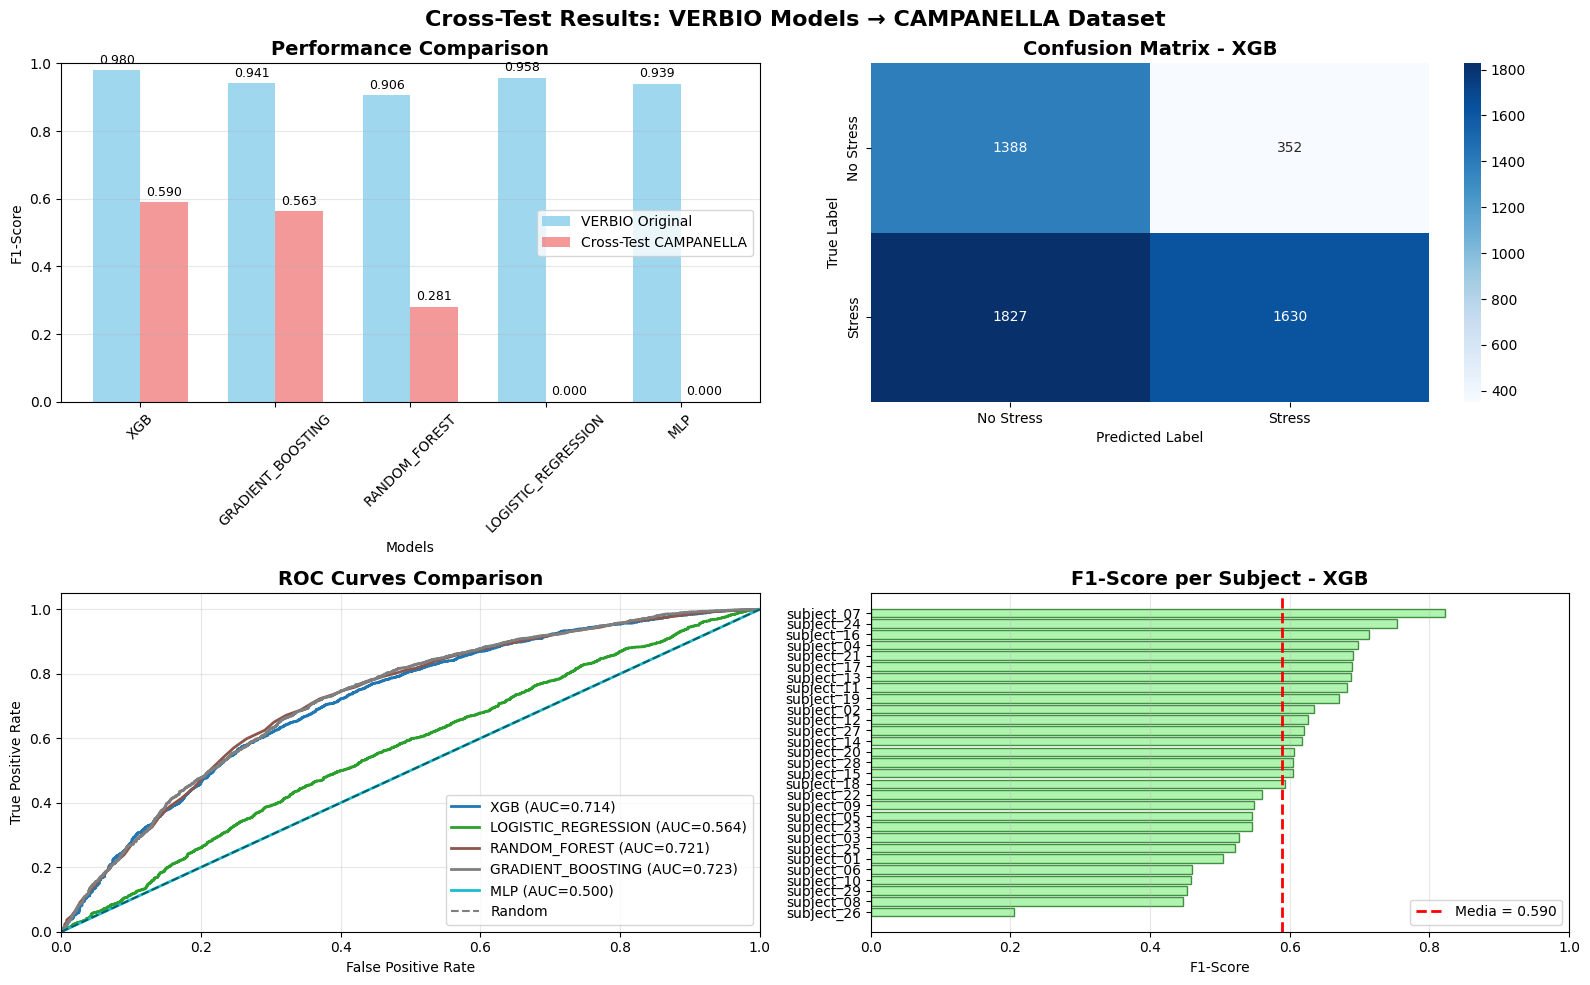


------------------------------------------------------------
ANALISI DISTRIBUZIONE PREDIZIONI
------------------------------------------------------------

XGB:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=61.86%, Stress=38.14%
  Campioni totali: 5197 (No-Stress: 3215, Stress: 1982)

LOGISTIC_REGRESSION:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=100.00%, Stress=0.00%
  Campioni totali: 5197 (No-Stress: 5197, Stress: 0)

RANDOM_FOREST:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=85.72%, Stress=14.28%
  Campioni totali: 5197 (No-Stress: 4455, Stress: 742)

GRADIENT_BOOSTING:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=64.98%, Stress=35.02%
  Campioni totali: 5197 (No-Stress: 3377, Stress: 1820)

MLP:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Str

In [ ]:
# =============================================================================
# CROSS TEST: MODELLI VERBIO → DATASET CAMPANELLA CON SOGLIA FISSA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI CAMPANELLA PER CROSS-TEST
# =============================================================================

# Prepara dati CAMPANELLA
X_campanella = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y_campanella = df['label'].values
groups_campanella = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print("="*70)
print("CROSS TEST: MODELLI VERBIO → DATASET CAMPANELLA")
print("="*70)
print(f"Dataset CAMPANELLA: {len(X_campanella)} campioni, {X_campanella.shape[1]} features, {len(np.unique(groups_campanella))} soggetti")

# =============================================================================
# FUNZIONE PER CROSS-TEST CON CALIBRAZIONE SOGLIE
# =============================================================================

# =============================================================================
# FUNZIONE PER CROSS-TEST CON SOGLIA FISSA
# =============================================================================

def cross_test_model(model_name, model_data, X, y, groups, logo):
    """Esegue cross-test di un singolo modello con LOSO"""

    print(f"\n{'-'*60}")
    print(f"CROSS-TEST: {model_name.upper()}")
    print(f"Original F1-Score VERBIO: {model_data['info']['f1_score']:.4f}")
    print(f"{'-'*60}")

    model = model_data['model']
    scaler = model_data['scaler']
    model_type = model_data['type']

    # Risultati per questo modello
    fold_results = []
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    print("Valutazione LOSO:")

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        subject = groups[test_idx[0]]
        print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

        # Dati di test
        X_test = X[test_idx]
        y_test = y[test_idx]

        # Skip se una sola classe nel test set
        if len(np.unique(y_test)) < 2:
            print("SKIP (una sola classe)")
            continue

        # Scaling con scaler VERBIO (senza refit!) - opzionale per tree-based models
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            # Per modelli tree-based che non richiedono scaling
            X_test_scaled = X_test

        try:
            # Predizione in base al tipo di modello con SOGLIA FISSA 0.5
            if model_type == 'sklearn':
                y_pred = model.predict(X_test_scaled)

                # Probabilità se disponibili
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_test_scaled)[:, 1]
                elif hasattr(model, 'decision_function'):
                    # Per SVM senza probability=True
                    decision_scores = model.decision_function(X_test_scaled)
                    # Normalizza tra 0 e 1 usando sigmoid
                    y_prob = 1 / (1 + np.exp(-decision_scores))
                else:
                    y_prob = y_pred.astype(float)  # Fallback

            elif model_type == 'keras':
                y_prob = model.predict(X_test_scaled, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA 0.5

            # Calcola metriche
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"F1={f1:.3f} Acc={acc:.3f}")

            # Salva risultati
            fold_results.append({
                'fold': fold + 1,
                'subject': subject,
                'n_samples': len(y_test),
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

            # Accumula per metriche globali
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

        except Exception as e:
            print(f"ERROR: {e}")
            continue

    # Calcola statistiche aggregate e mostra classification report
    if fold_results:
        results_df = pd.DataFrame(fold_results)

        print(f"\nRisultati {model_name.upper()}:")
        print(f"  F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
        print(f"  Accuracy media: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")

        # CLASSIFICATION REPORT GLOBALE per questo modello
        print(f"\nClassification Report Globale - {model_name.upper()}:")
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))

        # Performance drop rispetto a VERBIO
        performance_drop = model_data['info']['f1_score'] - results_df['f1_score'].mean()
        print(f"  Performance drop: {performance_drop:+.4f}")

        return {
            'model_name': model_name,
            'fold_results': fold_results,
            'results_df': results_df,
            'all_y_true': np.array(all_y_true),
            'all_y_pred': np.array(all_y_pred),
            'all_y_prob': np.array(all_y_prob),
            'original_f1': model_data['info']['f1_score'],
            'cross_test_f1': results_df['f1_score'].mean(),
            'performance_drop': performance_drop
        }
    else:
        print(f"Nessun risultato per {model_name}")
        return None

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

for model_name, model_data in verbio_models.items():
    if model_name in excluded_models:
        print(f"\n⚠️  SKIPPING {model_name.upper()} - Noto per fallimento cross-dataset")
        continue

    try:
        result = cross_test_model(model_name, model_data, X_campanella, y_campanella, groups_campanella, logo)
        if result is not None:
            cross_test_results[model_name] = result
    except Exception as e:
        print(f"Errore generale cross-test {model_name}: {e}")
        continue

# =============================================================================
# ANALISI COMPARATIVA E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if cross_test_results:
    print(f"\n{'='*70}")
    print("ANALISI COMPARATIVA CROSS-TEST")
    print(f"{'='*70}")

    # Crea tabella comparativa
    comparison_data = []
    for model_name, result in cross_test_results.items():
        comparison_data.append({
            'Model': model_name.upper(),
            'VERBIO_F1': result['original_f1'],
            'CrossTest_F1': result['cross_test_f1'],
            'Performance_Drop': result['performance_drop'],
            'N_Subjects': len(result['results_df'])
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('CrossTest_F1', ascending=False)

    print("Tabella Comparativa Performance:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    # Trova miglior modello cross-test
    best_model_name = comparison_df.iloc[0]['Model'].lower()
    best_result = cross_test_results[best_model_name]

    print(f"\nMiglior modello cross-test: {best_model_name.upper()}")
    print(f"F1-Score cross-test: {best_result['cross_test_f1']:.4f}")
    print(f"Performance drop: {best_result['performance_drop']:+.4f}")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (2x2 GRID)
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*50}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cross-Test Results: VERBIO Models → CAMPANELLA Dataset',
                 fontsize=16, fontweight='bold')

    # 1. COMPARISON BAR CHART (Top Left)
    models = comparison_df['Model']
    verbio_scores = comparison_df['VERBIO_F1']
    crosstest_scores = comparison_df['CrossTest_F1']

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[0,0].bar(x - width/2, verbio_scores, width, label='VERBIO Original',
                         color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, crosstest_scores, width, label='Cross-Test CAMPANELLA',
                         color='lightcoral', alpha=0.8)

    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('F1-Score')
    axes[0,0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    axes[0,0].set_ylim(0, 1)

    # Aggiungi valori sulle barre
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        axes[0,0].text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                      f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0,0].text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                      f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. CONFUSION MATRIX del miglior modello (Top Right)
    best_y_true = best_result['all_y_true']
    best_y_pred = best_result['all_y_pred']
    best_cm = confusion_matrix(best_y_true, best_y_pred)

    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')

    # 3. ROC CURVES COMPARATIVE (Bottom Left)
    colors_roc = plt.cm.tab10(np.linspace(0, 1, len(cross_test_results)))

    for i, (model_name, result) in enumerate(cross_test_results.items()):
        if len(result['all_y_true']) > 0:
            fpr, tpr, _ = roc_curve(result['all_y_true'], result['all_y_prob'])
            roc_auc_model = auc(fpr, tpr)

            axes[1,0].plot(fpr, tpr, color=colors_roc[i], lw=2,
                          label=f'{model_name.upper()} (AUC={roc_auc_model:.3f})')

    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. F1-SCORE DISTRIBUTION per miglior modello (Bottom Right)
    best_df = best_result['results_df'].sort_values('f1_score', ascending=True)

    bars = axes[1,1].barh(best_df['subject'], best_df['f1_score'],
                         color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1,1].set_xlabel('F1-Score')
    axes[1,1].set_title(f'F1-Score per Subject - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Linea media
    mean_f1 = best_df['f1_score'].mean()
    axes[1,1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                     label=f'Media = {mean_f1:.3f}')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Mostra analisi bilanciamento per ogni modello
    print(f"\n{'-'*60}")
    print("ANALISI DISTRIBUZIONE PREDIZIONI")
    print(f"{'-'*60}")

    for model_name, result in cross_test_results.items():
        y_true = result['all_y_true']
        y_pred = result['all_y_pred']

        # Distribuzione reale
        true_counts = np.bincount(y_true, minlength=2)
        true_ratio = true_counts / len(y_true)

        # Distribuzione predetta
        pred_counts = np.bincount(y_pred, minlength=2)
        pred_ratio = pred_counts / len(y_pred)

        print(f"\n{model_name.upper()}:")
        print(f"  Distribuzione reale:    No-Stress={true_ratio[0]:.2%}, Stress={true_ratio[1]:.2%}")
        print(f"  Distribuzione predetta: No-Stress={pred_ratio[0]:.2%}, Stress={pred_ratio[1]:.2%}")
        print(f"  Campioni totali: {len(y_pred)} (No-Stress: {pred_counts[0]}, Stress: {pred_counts[1]})")

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Directory per salvataggio
    save_dir = "/content/drive/MyDrive/CROSS_TEST_RESULTS/VERBIO_TO_CAMPANELLA"
    os.makedirs(save_dir, exist_ok=True)

    # Salva tabella comparativa
    comparison_path = os.path.join(save_dir, "verbio_to_campanella_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)

    # Salva dettagli per ogni modello
    for model_name, result in cross_test_results.items():
        model_path = os.path.join(save_dir, f"{model_name}_detailed_results.csv")
        result['results_df'].to_csv(model_path, index=False)

    # Salva summary JSON
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'CAMPANELLA',
        'method': 'cross_test_fixed_threshold',
        'best_model': best_model_name,
        'best_crosstest_f1': float(best_result['cross_test_f1']),
        'average_performance_drop': float(comparison_df['Performance_Drop'].mean()),
        'models_tested': list(cross_test_results.keys()),
        'excluded_models': excluded_models,
        'n_subjects': len(np.unique(groups_campanella))
    }

    summary_path = os.path.join(save_dir, "cross_test_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in: {save_dir}")
    print(f"  • Comparazione: {comparison_path}")
    print(f"  • Summary: {summary_path}")
    print(f"  • Dettagli per modello: {len(cross_test_results)} file CSV")

else:
    print("Nessun risultato cross-test disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("CROSS-TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING MLP VERBIO

✓ MLP VERBIO caricato
  F1-Score originale: 0.9394
  Miglior soggetto: P071
  Architettura: 16 layer

TRANSFER LEARNING MLP: VERBIO → CAMPANELLA
Dataset CAMPANELLA: 5197 campioni, 31 features, 29 soggetti
Parametri TL: 10 epoche max, LR=0.0001, Batch=16

Inizio Transfer Learning LOSO:
  Fold  1 - subject_01: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.298 (10ep) [COLLAPSE]
  Fold  2 - subject_02: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.311 (10ep) [COLLAPSE]
  Fold  3 - subject_03: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.369 (10ep) [COLLAPSE]
  Fold  4 - subject_04: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.363 (10ep) [COLLAPSE]
  Fold  5 - subject_05: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.370 (10ep) [COLLAPSE]
  Fold  6 - subject_06: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.349 (10ep) [COLLAPSE]
  Fold  7 - subject_07: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.356 (10ep) [COLLAPSE]
  Fold  8 - subject_08: Frozen layers: 15, Trainable: 1 F1=0.00

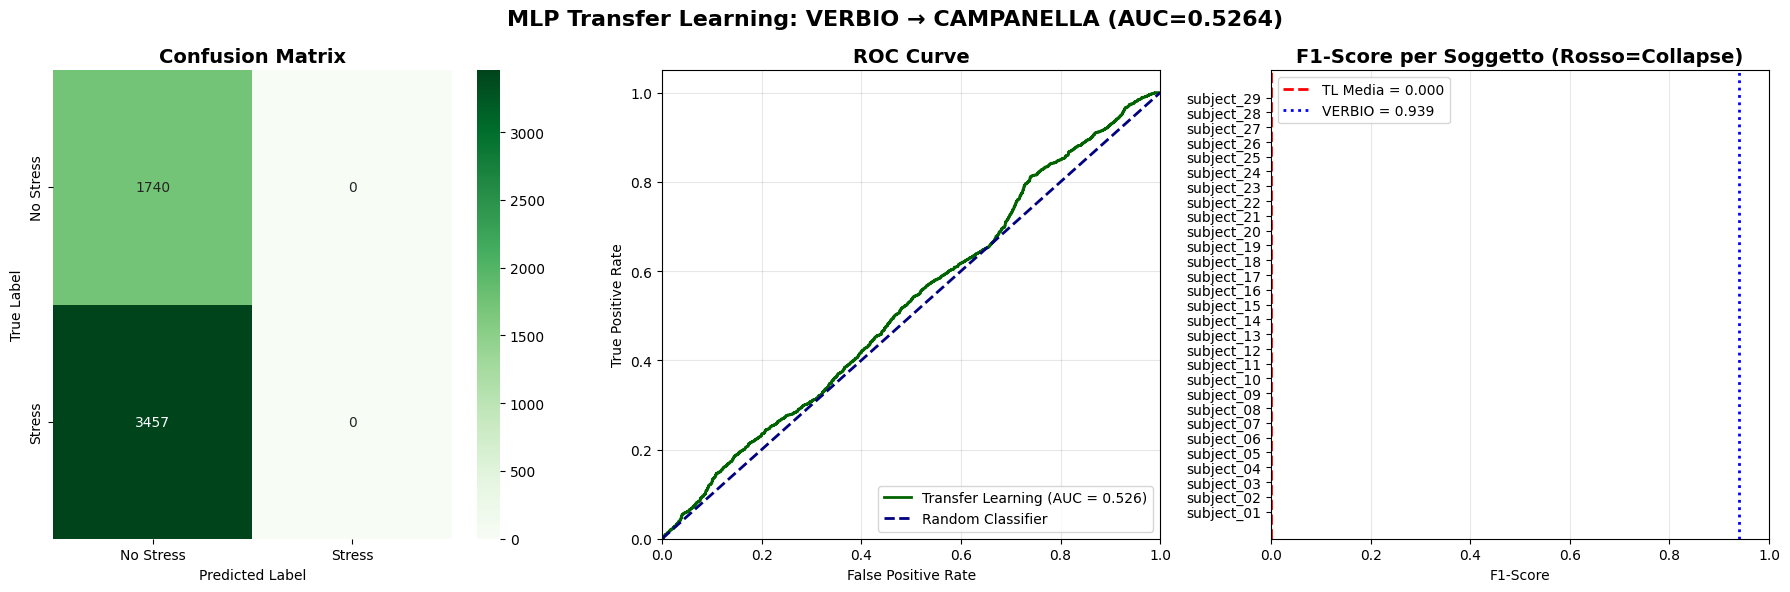


✓ Risultati salvati in:
  • Dettagli: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/VERBIO_TO_CAMPANELLA/mlp_transfer_learning_results.csv
  • Summary: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/VERBIO_TO_CAMPANELLA/mlp_transfer_learning_summary.json

TRANSFER LEARNING MLP COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING MLP: VERBIO → CAMPANELLA (VISUALIZZAZIONI RIDOTTE)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO MLP VERBIO
# =============================================================================

def load_verbio_mlp():
    """Carica il miglior modello MLP da VERBIO"""
    model_dir = "/content/drive/MyDrive/BEST_MODELS/VERBIO/MLP"

    model_path = os.path.join(model_dir, "mlp_best_loso_model.keras")
    scaler_path = os.path.join(model_dir, "mlp_best_loso_scaler.pkl")
    info_path = os.path.join(model_dir, "mlp_best_model_info.json")

    try:
        # Carica modello
        model = load_model(model_path)

        # Carica scaler
        scaler = joblib.load(scaler_path)

        # Carica info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ MLP VERBIO caricato")
        print(f"  F1-Score originale: {info['f1_score']:.4f}")
        print(f"  Miglior soggetto: {info['subject']}")
        print(f"  Architettura: {len(model.layers)} layer")

        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento MLP VERBIO: {e}")
        return None, None, None

# Carica modello MLP VERBIO
verbio_mlp, verbio_scaler, verbio_info = load_verbio_mlp()

if verbio_mlp is None:
    print("[ERROR] Impossibile procedere senza modello MLP VERBIO!")
    exit()

# =============================================================================
# SETUP DATI CAMPANELLA PER TRANSFER LEARNING
# =============================================================================

# Prepara dati CAMPANLLA
X_campanella = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y_campanella = df['label'].values
groups_campanella = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP: VERBIO → CAMPANELLA")
print(f"{'='*70}")
print(f"Dataset CAMPANELLA: {len(X_campanella)} campioni, {X_campanella.shape[1]} features, {len(np.unique(groups_campanella))} soggetti")

# =============================================================================
# PARAMETRI TRANSFER LEARNING
# =============================================================================

# Parametri ottimali per evitare overfitting e class collapse
TL_EPOCHS = 10           # Epoche limitate per fine-tuning
TL_LR = 0.0001          # Learning rate molto basso
TL_BATCH_SIZE = 16      # Batch size piccolo
TL_PATIENCE = 5         # Patience per early stopping

print(f"Parametri TL: {TL_EPOCHS} epoche max, LR={TL_LR}, Batch={TL_BATCH_SIZE}")

# =============================================================================
# TRANSFER LEARNING LOSO
# =============================================================================

# Risultati per questo esperimento
transfer_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

print("\nInizio Transfer Learning LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_campanella, y_campanella, groups_campanella)):
    subject = groups_campanella[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepara dati
    X_train, X_test = X_campanella[train_idx], X_campanella[test_idx]
    y_train, y_test = y_campanella[train_idx], y_campanella[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # SCALING: Usa scaler VERBIO su CAMPANELLA (SENZA refit)
    X_train_scaled = verbio_scaler.transform(X_train)
    X_test_scaled = verbio_scaler.transform(X_test)

    try:
        # === CLONE DEL MODELLO VERBIO ===
        transfer_model = clone_model(verbio_mlp)
        transfer_model.set_weights(verbio_mlp.get_weights())

        # === CONGELA TUTTI I LAYER TRANNE L'ULTIMO ===
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False

        # Solo l'ultimo layer (classificazione) è trainable
        transfer_model.layers[-1].trainable = True

        print(f"Frozen layers: {len(transfer_model.layers)-1}, Trainable: 1", end=" ")

        # === CLASS WEIGHTS PER BILANCIAMENTO ===
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced',
                                               classes=unique_classes,
                                               y=y_train)
            class_weight_dict = dict(zip(unique_classes, class_weights))
        else:
            class_weight_dict = None

        # === COMPILA CON PARAMETRI CONSERVATIVI ===
        transfer_model.compile(
            optimizer=Adam(learning_rate=TL_LR, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # === CALLBACKS PER CONTROLLO TRAINING ===
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=TL_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=0
        )

        # === FINE-TUNING TRAINING ===
        history = transfer_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=TL_EPOCHS,
            batch_size=TL_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # === PREDIZIONI CON SOGLIA FISSA ===
        y_prob = transfer_model.predict(X_test_scaled, verbose=0).flatten()
        y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA, NESSUNA CORREZIONE

        # Verifica class collapse (solo per documentazione)
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            collapse_warning = " [COLLAPSE]"
        else:
            collapse_warning = ""

        # === CALCOLA METRICHE ===
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        epochs_used = len(history.history['loss'])
        print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep){collapse_warning}")

        # === SALVA RISULTATI (inclusa informazione sul collapse) ===
        transfer_results.append({
            'fold': fold + 1,
            'subject': subject,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': epochs_used,
            'predicted_classes': len(unique_pred),
            'class_collapsed': len(unique_pred) == 1
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_subjects.extend([subject] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# ANALISI RISULTATI E CONFRONTI
# =============================================================================

print(f"\n{'-'*60}")
print("RISULTATI TRANSFER LEARNING MLP")
print(f"{'-'*60}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['class_collapsed'] == True]
    successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
    success_rate = (len(successful_folds) / len(transfer_df)) * 100 if len(transfer_df) > 0 else 0

    print(f"Fold completati: {len(transfer_df)}")
    print(f"Fold con class collapse: {len(collapse_folds)}")
    print(f"Fold successful: {len(successful_folds)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successful_folds) > 0:
        print(f"F1-Score medio (solo fold successful): {successful_folds['f1_score'].mean():.4f} ± {successful_folds['f1_score'].std():.4f}")
    else:
        print("ATTENZIONE: Nessun fold successful - transfer learning fallito")

    # Statistiche per soggetto
    print(f"\nRisultati dettagliati:")
    display_cols = ['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used', 'class_collapsed']
    print(transfer_df[display_cols].to_string(index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    # Confronto con VERBIO originale
    print(f"\n{'-'*60}")
    print("CONFRONTO PERFORMANCE")
    print(f"{'-'*60}")

    verbio_f1 = verbio_info['f1_score']
    transfer_f1 = transfer_df['f1_score'].mean()
    improvement = transfer_f1 - verbio_f1
    improvement_pct = (improvement / verbio_f1) * 100

    print(f"VERBIO F1-Score originale: {verbio_f1:.4f}")
    print(f"Transfer Learning F1:     {transfer_f1:.4f}")
    print(f"Miglioramento assoluto:   {improvement:+.4f}")
    print(f"Miglioramento relativo:   {improvement_pct:+.2f}%")

    # Range performance
    print(f"\nRange F1-Score: {transfer_df['f1_score'].min():.4f} - {transfer_df['f1_score'].max():.4f}")
    best_subject = transfer_df.loc[transfer_df['f1_score'].idxmax(), 'subject']
    worst_subject = transfer_df.loc[transfer_df['f1_score'].idxmin(), 'subject']
    print(f"Miglior soggetto: {best_subject} (F1={transfer_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {worst_subject} (F1={transfer_df['f1_score'].min():.4f})")

# =============================================================================
# METRICHE GLOBALI E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    print(f"\n{'-'*60}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*60}")

    # Verifica globale class collapse
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")

    if global_unique_pred == 1:
        print("⚠️ ATTENZIONE: Solo una classe predetta globalmente - Transfer Learning ha fallito!")
        predicted_class = all_y_pred[0]
        print(f"   Classe predetta: {predicted_class} ({'Stress' if predicted_class == 1 else 'No Stress'})")
        print("   Tutte le metriche saranno compromesse dal class collapse.")
    else:
        print("✅ Transfer Learning successful - Entrambe le classi predette")

    # Classification Report globale
    print("\nClassification Report Globale:")
    try:
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))
    except:
        print("Impossibile calcolare classification report a causa del class collapse")

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback - class collapse)")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (1x3 GRID)
    # =============================================================================

    print(f"\n{'-'*60}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*60}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'MLP Transfer Learning: VERBIO → CAMPANELLA (AUC={roc_auc:.4f})',
                 fontsize=16, fontweight='bold')

    # 1. CONFUSION MATRIX (Left)
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. ROC CURVE (Middle)
    axes[1].plot(fpr, tpr, color='darkgreen', lw=2,
                 label=f'Transfer Learning (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO (Right)
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base al class collapse
        colors = ['red' if collapsed else 'lightgreen'
                 for collapsed in transfer_df_sorted['class_collapsed']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                       label=f'TL Media = {mean_f1_tl:.3f}')
        axes[2].axvline(x=verbio_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                       label=f'VERBIO = {verbio_info["f1_score"]:.3f}')

        # Linea per media solo fold successful (se esistono)
        successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
        if len(successful_folds) > 0:
            mean_f1_successful = successful_folds['f1_score'].mean()
            axes[2].axvline(x=mean_f1_successful, color='green', linestyle='-', linewidth=2,
                           label=f'TL Success = {mean_f1_successful:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/VERBIO_TO_CAMPANELLA"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "mlp_transfer_learning_results.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary completo
    summary = {
        'experiment': 'MLP_Transfer_Learning',
        'source_dataset': 'VERBIO',
        'target_dataset': 'CAMPANELLA',
        'source_f1': float(verbio_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'performance_improvement': float(improvement),
        'improvement_percentage': float(improvement_pct),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'success_rate': float(success_rate),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'class_collapse_folds': int(len(collapse_folds)),
        'successful_folds': int(len(successful_folds)),
        'global_classes_predicted': int(global_unique_pred),
        'parameters': {
            'epochs': TL_EPOCHS,
            'learning_rate': TL_LR,
            'batch_size': TL_BATCH_SIZE,
            'patience': TL_PATIENCE
        }
    }

    summary_path = os.path.join(save_dir, "mlp_transfer_learning_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in:")
    print(f"  • Dettagli: {results_path}")
    print(f"  • Summary: {summary_path}")

else:
    print("[WARNING] Nessun risultato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP COMPLETATO!")
print(f"{'='*70}")

AFFECTIVE ROAD --> CAMPANELLA

CROSS TEST

In [ ]:
# =============================================================================
# CARICAMENTO MIGLIORI MODELLI AFFECTIVE ROAD E RELATIVI SCALER
# =============================================================================

import joblib
import json
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE FUNZIONI DI CARICAMENTO
# =============================================================================

def load_sklearn_model(model_dir, model_name):
    """Carica modello sklearn, scaler (opzionale) e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.pkl")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento modello (obbligatorio)
        model = joblib.load(model_path)

        # Caricamento scaler (opzionale per tree-based models)
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            scaling_required = True
        else:
            scaler = None
            scaling_required = False
            print(f"  ⚠️  {model_name.upper()}: Scaler non trovato - Tree-based model, scaling non necessario")

        # Caricamento info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

def load_keras_model(model_dir, model_name):
    """Carica modello Keras, scaler e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.keras")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

# =============================================================================
# CARICAMENTO MODELLI AFFECTIVE ROAF
# =============================================================================

print("="*60)
print("CARICAMENTO MIGLIORI MODELLI AFFECTIVE ROAD")
print("="*60)

base_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD"

# Dizionario per memorizzare tutti i modelli
affectiveroad_models = {}

# Modelli sklearn
sklearn_models = ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting']
for model_name in sklearn_models:
    model_dir = os.path.join(base_dir, model_name.upper())
    if os.path.exists(model_dir):
        model, scaler, info = load_sklearn_model(model_dir, model_name)
        if model is not None:
            affectiveroad_models[model_name] = {
                'model': model,
                'scaler': scaler,
                'info': info,
                'type': 'sklearn'
            }

# Modello MLP (Keras)
mlp_dir = os.path.join(base_dir, "MLP")
if os.path.exists(mlp_dir):
    model, scaler, info = load_keras_model(mlp_dir, "mlp")
    if model is not None:
        affectiveroad_models['mlp'] = {
            'model': model,
            'scaler': scaler,
            'info': info,
            'type': 'keras'
        }

print(f"\n✓ Totale modelli caricati: {len(affectiveroad_models)}")
print("Modelli disponibili:", list(affectiveroad_models.keys()))

# =============================================================================
# VERIFICA FEATURE COMPATIBILITY
# =============================================================================

print(f"\n{'-'*50}")
print("VERIFICA COMPATIBILITÀ FEATURE")
print(f"{'-'*50}")

# Verifica che le feature del dataset CAMPANELLA siano compatibili con AFFECTIVE ROAD
campanella_features = df.drop(columns=['label', 'subject', 'protocol_phase']).columns
n_campanella_features = len(campanella_features)

print(f"Features CAMPANELLA: {n_campanella_features}")

for model_name, model_data in affectiveroad_models.items():
    try:
        if model_data['type'] == 'sklearn':
            # Per modelli sklearn, verifica n_features_in_
            expected_features = model_data['model'].n_features_in_
        elif model_data['type'] == 'keras':
            # Per modelli Keras, verifica input_shape
            expected_features = model_data['model'].input_shape[1]

        if expected_features == n_campanella_features:
            print(f"✓ {model_name.upper()}: Compatible ({expected_features} features)")
        else:
            print(f"✗ {model_name.upper()}: Incompatible - Expected: {expected_features}, Got: {n_campanella_features}")

    except Exception as e:
        print(f"✗ {model_name.upper()}: Error checking compatibility - {e}")

print(f"\n{'-'*50}")
print("MODELLI PRONTI PER CROSS-TEST")
print(f"{'-'*50}")

CARICAMENTO MIGLIORI MODELLI AFFECTIVE ROAD
✓ SVM caricato - F1: 0.7720, Soggetto: Drv3
✓ XGB caricato - F1: 0.7806, Soggetto: Drv3
✓ LOGISTIC_REGRESSION caricato - F1: 0.7679, Soggetto: Drv3
  ⚠️  RANDOM_FOREST: Scaler non trovato - Tree-based model, scaling non necessario
✓ RANDOM_FOREST caricato - F1: 0.7547, Soggetto: Drv3
✓ GRADIENT_BOOSTING caricato - F1: 0.7627, Soggetto: Drv3
✓ MLP caricato - F1: 0.7768, Soggetto: Drv3

✓ Totale modelli caricati: 6
Modelli disponibili: ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting', 'mlp']

--------------------------------------------------
VERIFICA COMPATIBILITÀ FEATURE
--------------------------------------------------
Features CAMPANELLA: 31
✓ SVM: Compatible (31 features)
✓ XGB: Compatible (31 features)
✓ LOGISTIC_REGRESSION: Compatible (31 features)
✓ RANDOM_FOREST: Compatible (31 features)
✓ GRADIENT_BOOSTING: Compatible (31 features)
✓ MLP: Compatible (31 features)

--------------------------------------------

CROSS TEST: MODELLI AFFECTIVE ROAD → DATASET CAMPANELLA
Dataset CAMPANELLA: 5197 campioni, 31 features, 29 soggetti

⚠️  SKIPPING SVM - Noto per fallimento cross-dataset

------------------------------------------------------------
CROSS-TEST: XGB
Original F1-Score AFFECTIVE ROAD: 0.7806
------------------------------------------------------------
Valutazione LOSO:
  Fold  1 - subject_01: F1=0.226 Acc=0.341
  Fold  2 - subject_02: F1=0.471 Acc=0.487
  Fold  3 - subject_03: F1=0.470 Acc=0.530
  Fold  4 - subject_04: F1=0.114 Acc=0.363
  Fold  5 - subject_05: F1=0.503 Acc=0.543
  Fold  6 - subject_06: F1=0.412 Acc=0.463
  Fold  7 - subject_07: F1=0.233 Acc=0.431
  Fold  8 - subject_08: F1=0.365 Acc=0.454
  Fold  9 - subject_09: F1=0.494 Acc=0.541
  Fold 10 - subject_10: F1=0.356 Acc=0.423
  Fold 11 - subject_11: F1=0.035 Acc=0.358
  Fold 12 - subject_12: F1=0.340 Acc=0.423
  Fold 13 - subject_13: F1=0.179 Acc=0.375
  Fold 14 - subject_14: F1=0.437 Acc=0.455
  Fold 15 - subject_15: F1=0.3

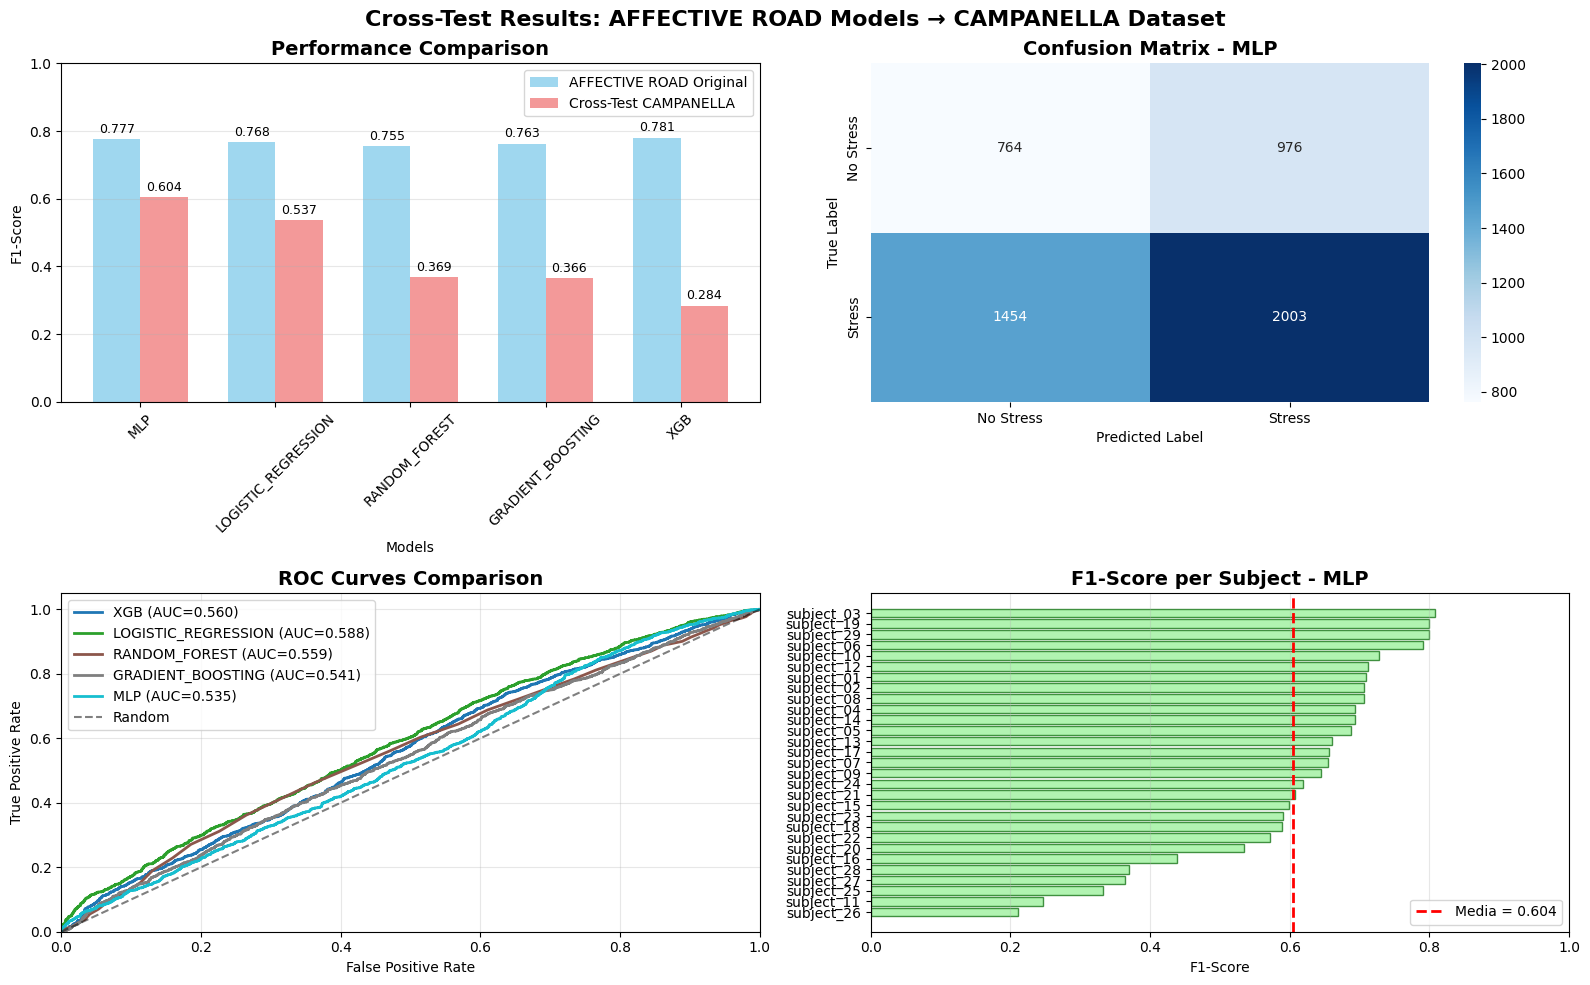


------------------------------------------------------------
ANALISI DISTRIBUZIONE PREDIZIONI
------------------------------------------------------------

XGB:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=82.99%, Stress=17.01%
  Campioni totali: 5197 (No-Stress: 4313, Stress: 884)

LOGISTIC_REGRESSION:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=55.13%, Stress=44.87%
  Campioni totali: 5197 (No-Stress: 2865, Stress: 2332)

RANDOM_FOREST:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=75.76%, Stress=24.24%
  Campioni totali: 5197 (No-Stress: 3937, Stress: 1260)

GRADIENT_BOOSTING:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-Stress=75.62%, Stress=24.38%
  Campioni totali: 5197 (No-Stress: 3930, Stress: 1267)

MLP:
  Distribuzione reale:    No-Stress=33.48%, Stress=66.52%
  Distribuzione predetta: No-

In [ ]:
# =============================================================================
# CROSS TEST: MODELLI AFFECTIVE ROAD → DATASET CAMPANELLA CON SOGLIA FISSA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI CAMPANELLA PER CROSS-TEST
# =============================================================================

# Prepara dati CAMOANELLA
X_campanella = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y_campanella = df['label'].values
groups_campanella = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print("="*70)
print("CROSS TEST: MODELLI AFFECTIVE ROAD → DATASET CAMPANELLA")
print("="*70)
print(f"Dataset CAMPANELLA: {len(X_campanella)} campioni, {X_campanella.shape[1]} features, {len(np.unique(groups_campanella))} soggetti")

# =============================================================================
# FUNZIONE PER CROSS-TEST CON CALIBRAZIONE SOGLIE
# =============================================================================

# =============================================================================
# FUNZIONE PER CROSS-TEST CON SOGLIA FISSA
# =============================================================================

def cross_test_model(model_name, model_data, X, y, groups, logo):
    """Esegue cross-test di un singolo modello con LOSO"""

    print(f"\n{'-'*60}")
    print(f"CROSS-TEST: {model_name.upper()}")
    print(f"Original F1-Score AFFECTIVE ROAD: {model_data['info']['f1_score']:.4f}")
    print(f"{'-'*60}")

    model = model_data['model']
    scaler = model_data['scaler']
    model_type = model_data['type']

    # Risultati per questo modello
    fold_results = []
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    print("Valutazione LOSO:")

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        subject = groups[test_idx[0]]
        print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

        # Dati di test
        X_test = X[test_idx]
        y_test = y[test_idx]

        # Skip se una sola classe nel test set
        if len(np.unique(y_test)) < 2:
            print("SKIP (una sola classe)")
            continue

        # Scaling con scaler AFFECTIVE ROAD (senza refit!) - opzionale per tree-based models
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            # Per modelli tree-based che non richiedono scaling
            X_test_scaled = X_test

        try:
            # Predizione in base al tipo di modello con SOGLIA FISSA 0.5
            if model_type == 'sklearn':
                y_pred = model.predict(X_test_scaled)

                # Probabilità se disponibili
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_test_scaled)[:, 1]
                elif hasattr(model, 'decision_function'):
                    # Per SVM senza probability=True
                    decision_scores = model.decision_function(X_test_scaled)
                    # Normalizza tra 0 e 1 usando sigmoid
                    y_prob = 1 / (1 + np.exp(-decision_scores))
                else:
                    y_prob = y_pred.astype(float)  # Fallback

            elif model_type == 'keras':
                y_prob = model.predict(X_test_scaled, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA 0.5

            # Calcola metriche
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"F1={f1:.3f} Acc={acc:.3f}")

            # Salva risultati
            fold_results.append({
                'fold': fold + 1,
                'subject': subject,
                'n_samples': len(y_test),
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

            # Accumula per metriche globali
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

        except Exception as e:
            print(f"ERROR: {e}")
            continue

    # Calcola statistiche aggregate e mostra classification report
    if fold_results:
        results_df = pd.DataFrame(fold_results)

        print(f"\nRisultati {model_name.upper()}:")
        print(f"  F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
        print(f"  Accuracy media: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")

        # CLASSIFICATION REPORT GLOBALE per questo modello
        print(f"\nClassification Report Globale - {model_name.upper()}:")
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))

        # Performance drop rispetto a AFFECTIVE ROAD
        performance_drop = model_data['info']['f1_score'] - results_df['f1_score'].mean()
        print(f"  Performance drop: {performance_drop:+.4f}")

        return {
            'model_name': model_name,
            'fold_results': fold_results,
            'results_df': results_df,
            'all_y_true': np.array(all_y_true),
            'all_y_pred': np.array(all_y_pred),
            'all_y_prob': np.array(all_y_prob),
            'original_f1': model_data['info']['f1_score'],
            'cross_test_f1': results_df['f1_score'].mean(),
            'performance_drop': performance_drop
        }
    else:
        print(f"Nessun risultato per {model_name}")
        return None

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

for model_name, model_data in affectiveroad_models.items():
    if model_name in excluded_models:
        print(f"\n⚠️  SKIPPING {model_name.upper()} - Noto per fallimento cross-dataset")
        continue

    try:
        result = cross_test_model(model_name, model_data, X_campanella, y_campanella, groups_campanella, logo)
        if result is not None:
            cross_test_results[model_name] = result
    except Exception as e:
        print(f"Errore generale cross-test {model_name}: {e}")
        continue

# =============================================================================
# ANALISI COMPARATIVA E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if cross_test_results:
    print(f"\n{'='*70}")
    print("ANALISI COMPARATIVA CROSS-TEST")
    print(f"{'='*70}")

    # Crea tabella comparativa
    comparison_data = []
    for model_name, result in cross_test_results.items():
        comparison_data.append({
            'Model': model_name.upper(),
            'AFFECTIVEROAD_F1': result['original_f1'],
            'CrossTest_F1': result['cross_test_f1'],
            'Performance_Drop': result['performance_drop'],
            'N_Subjects': len(result['results_df'])
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('CrossTest_F1', ascending=False)

    print("Tabella Comparativa Performance:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    # Trova miglior modello cross-test
    best_model_name = comparison_df.iloc[0]['Model'].lower()
    best_result = cross_test_results[best_model_name]

    print(f"\nMiglior modello cross-test: {best_model_name.upper()}")
    print(f"F1-Score cross-test: {best_result['cross_test_f1']:.4f}")
    print(f"Performance drop: {best_result['performance_drop']:+.4f}")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (2x2 GRID)
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*50}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cross-Test Results: AFFECTIVE ROAD Models → CAMPANELLA Dataset',
                 fontsize=16, fontweight='bold')

    # 1. COMPARISON BAR CHART (Top Left)
    models = comparison_df['Model']
    affectiveroad_scores = comparison_df['AFFECTIVEROAD_F1']
    crosstest_scores = comparison_df['CrossTest_F1']

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[0,0].bar(x - width/2, affectiveroad_scores, width, label='AFFECTIVE ROAD Original',
                         color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, crosstest_scores, width, label='Cross-Test CAMPANELLA',
                         color='lightcoral', alpha=0.8)

    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('F1-Score')
    axes[0,0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    axes[0,0].set_ylim(0, 1)

    # Aggiungi valori sulle barre
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        axes[0,0].text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                      f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0,0].text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                      f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. CONFUSION MATRIX del miglior modello (Top Right)
    best_y_true = best_result['all_y_true']
    best_y_pred = best_result['all_y_pred']
    best_cm = confusion_matrix(best_y_true, best_y_pred)

    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')

    # 3. ROC CURVES COMPARATIVE (Bottom Left)
    colors_roc = plt.cm.tab10(np.linspace(0, 1, len(cross_test_results)))

    for i, (model_name, result) in enumerate(cross_test_results.items()):
        if len(result['all_y_true']) > 0:
            fpr, tpr, _ = roc_curve(result['all_y_true'], result['all_y_prob'])
            roc_auc_model = auc(fpr, tpr)

            axes[1,0].plot(fpr, tpr, color=colors_roc[i], lw=2,
                          label=f'{model_name.upper()} (AUC={roc_auc_model:.3f})')

    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. F1-SCORE DISTRIBUTION per miglior modello (Bottom Right)
    best_df = best_result['results_df'].sort_values('f1_score', ascending=True)

    bars = axes[1,1].barh(best_df['subject'], best_df['f1_score'],
                         color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1,1].set_xlabel('F1-Score')
    axes[1,1].set_title(f'F1-Score per Subject - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Linea media
    mean_f1 = best_df['f1_score'].mean()
    axes[1,1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                     label=f'Media = {mean_f1:.3f}')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Mostra analisi bilanciamento per ogni modello
    print(f"\n{'-'*60}")
    print("ANALISI DISTRIBUZIONE PREDIZIONI")
    print(f"{'-'*60}")

    for model_name, result in cross_test_results.items():
        y_true = result['all_y_true']
        y_pred = result['all_y_pred']

        # Distribuzione reale
        true_counts = np.bincount(y_true, minlength=2)
        true_ratio = true_counts / len(y_true)

        # Distribuzione predetta
        pred_counts = np.bincount(y_pred, minlength=2)
        pred_ratio = pred_counts / len(y_pred)

        print(f"\n{model_name.upper()}:")
        print(f"  Distribuzione reale:    No-Stress={true_ratio[0]:.2%}, Stress={true_ratio[1]:.2%}")
        print(f"  Distribuzione predetta: No-Stress={pred_ratio[0]:.2%}, Stress={pred_ratio[1]:.2%}")
        print(f"  Campioni totali: {len(y_pred)} (No-Stress: {pred_counts[0]}, Stress: {pred_counts[1]})")

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Directory per salvataggio
    save_dir = "/content/drive/MyDrive/CROSS_TEST_RESULTS/AFFECTIVEROAD_TO_CAMPANELLA"
    os.makedirs(save_dir, exist_ok=True)

    # Salva tabella comparativa
    comparison_path = os.path.join(save_dir, "affectiveroad_to_campanella_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)

    # Salva dettagli per ogni modello
    for model_name, result in cross_test_results.items():
        model_path = os.path.join(save_dir, f"{model_name}_detailed_results.csv")
        result['results_df'].to_csv(model_path, index=False)

    # Salva summary JSON
    summary = {
        'source_dataset': 'AFFECTIVE ROAD',
        'target_dataset': 'CAMPANELLA',
        'method': 'cross_test_fixed_threshold',
        'best_model': best_model_name,
        'best_crosstest_f1': float(best_result['cross_test_f1']),
        'average_performance_drop': float(comparison_df['Performance_Drop'].mean()),
        'models_tested': list(cross_test_results.keys()),
        'excluded_models': excluded_models,
        'n_subjects': len(np.unique(groups_campanella))
    }

    summary_path = os.path.join(save_dir, "cross_test_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in: {save_dir}")
    print(f"  • Comparazione: {comparison_path}")
    print(f"  • Summary: {summary_path}")
    print(f"  • Dettagli per modello: {len(cross_test_results)} file CSV")

else:
    print("Nessun risultato cross-test disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("CROSS-TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING MLP AFFECTIVE ROAD

✓ MLP AFFECTIVE ROAD caricato
  F1-Score originale: 0.7768
  Miglior soggetto: Drv3
  Architettura: 16 layer

TRANSFER LEARNING MLP: AFFECTIVE ROAD → CAMPANELLA
Dataset CAMPANELLA: 5197 campioni, 31 features, 29 soggetti
Parametri TL: 10 epoche max, LR=0.0001, Batch=16

Inizio Transfer Learning LOSO:
  Fold  1 - subject_01: Frozen layers: 15, Trainable: 1 F1=0.705 Acc=0.625 (6ep)
  Fold  2 - subject_02: Frozen layers: 15, Trainable: 1 F1=0.705 Acc=0.596 (10ep)
  Fold  3 - subject_03: Frozen layers: 15, Trainable: 1 F1=0.805 Acc=0.726 (10ep)
  Fold  4 - subject_04: Frozen layers: 15, Trainable: 1 F1=0.694 Acc=0.614 (9ep)
  Fold  5 - subject_05: Frozen layers: 15, Trainable: 1 F1=0.673 Acc=0.578 (10ep)
  Fold  6 - subject_06: Frozen layers: 15, Trainable: 1 F1=0.780 Acc=0.691 (10ep)
  Fold  7 - subject_07: Frozen layers: 15, Trainable: 1 F1=0.551 Acc=0.494 (10ep)
  Fold  8 - subject_08: Frozen layers: 15, Trainable: 1 F1=0.689 Acc=0.557 (10ep)
  Fold  9 - subject_09: Frozen layers: 15, T

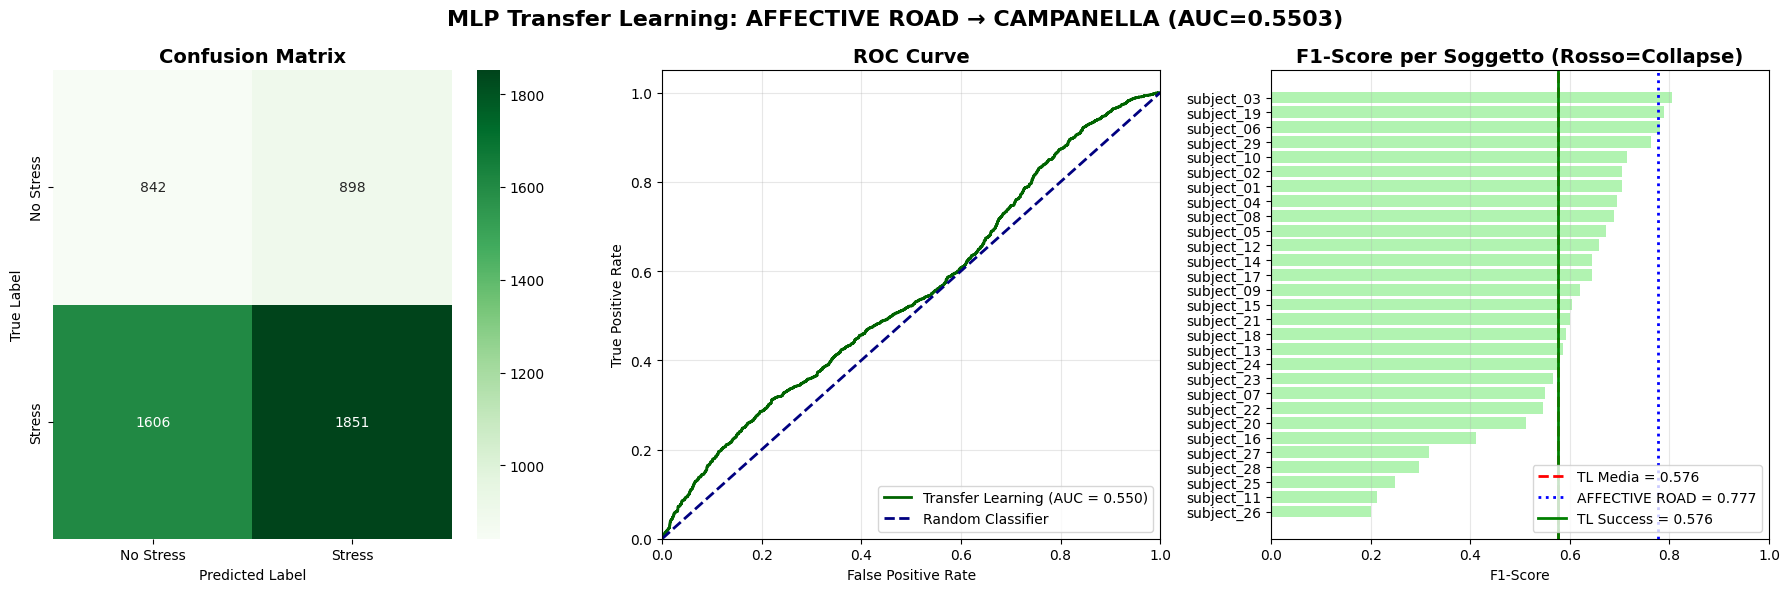


✓ Risultati salvati in:
  • Dettagli: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/AFFECTIVEROAD_TO_CAMPANELLA/mlp_transfer_learning_results.csv
  • Summary: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/AFFECTIVEROAD_TO_CAMPANELLA/mlp_transfer_learning_summary.json

TRANSFER LEARNING MLP COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING MLP: AFFECTIVE ROAD → CAMPANELLA (VISUALIZZAZIONI RIDOTTE)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO MLP AFFECTIVE ROAD
# =============================================================================

def load_affectiveroad_mlp():
    """Carica il miglior modello MLP da AFFECTIVE ROAD"""
    model_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/MLP"

    model_path = os.path.join(model_dir, "mlp_best_loso_model.keras")
    scaler_path = os.path.join(model_dir, "mlp_best_loso_scaler.pkl")
    info_path = os.path.join(model_dir, "mlp_best_model_info.json")

    try:
        # Carica modello
        model = load_model(model_path)

        # Carica scaler
        scaler = joblib.load(scaler_path)

        # Carica info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ MLP AFFECTIVE ROAD caricato")
        print(f"  F1-Score originale: {info['f1_score']:.4f}")
        print(f"  Miglior soggetto: {info['subject']}")
        print(f"  Architettura: {len(model.layers)} layer")

        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento MLP AFFECTIVE ROAD: {e}")
        return None, None, None

# Carica modello MLP AFFECTIVE ROAD
affectiveroad_mlp, affectiveroad_scaler, affectiveroad_info = load_affectiveroad_mlp()

if affectiveroad_mlp is None:
    print("[ERROR] Impossibile procedere senza modello MLP AFFECTIVE ROAD!")
    exit()

# =============================================================================
# SETUP DATI CAMPANELLA PER TRANSFER LEARNING
# =============================================================================

# Prepara dati CAMPANELLA
X_campanella = df.drop(columns=['label', 'subject', 'protocol_phase']).values
y_campanella = df['label'].values
groups_campanella = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP: AFFECTIVE ROAD → CAMPANELLA")
print(f"{'='*70}")
print(f"Dataset CAMPANELLA: {len(X_campanella)} campioni, {X_campanella.shape[1]} features, {len(np.unique(groups_campanella))} soggetti")

# =============================================================================
# PARAMETRI TRANSFER LEARNING
# =============================================================================

# Parametri ottimali per evitare overfitting e class collapse
TL_EPOCHS = 10           # Epoche limitate per fine-tuning
TL_LR = 0.0001          # Learning rate molto basso
TL_BATCH_SIZE = 16      # Batch size piccolo
TL_PATIENCE = 5         # Patience per early stopping

print(f"Parametri TL: {TL_EPOCHS} epoche max, LR={TL_LR}, Batch={TL_BATCH_SIZE}")

# =============================================================================
# TRANSFER LEARNING LOSO
# =============================================================================

# Risultati per questo esperimento
transfer_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

print("\nInizio Transfer Learning LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_campanella, y_campanella, groups_campanella)):
    subject = groups_campanella[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepara dati
    X_train, X_test = X_campanella[train_idx], X_campanella[test_idx]
    y_train, y_test = y_campanella[train_idx], y_campanella[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # SCALING: Usa scaler AFFECTIVE ROAD su CAMPANELLA (SENZA refit)
    X_train_scaled = affectiveroad_scaler.transform(X_train)
    X_test_scaled = affectiveroad_scaler.transform(X_test)

    try:
        # === CLONE DEL MODELLO AFFECTIVE ROAD ===
        transfer_model = clone_model(affectiveroad_mlp)
        transfer_model.set_weights(affectiveroad_mlp.get_weights())

        # === CONGELA TUTTI I LAYER TRANNE L'ULTIMO ===
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False

        # Solo l'ultimo layer (classificazione) è trainable
        transfer_model.layers[-1].trainable = True

        print(f"Frozen layers: {len(transfer_model.layers)-1}, Trainable: 1", end=" ")

        # === CLASS WEIGHTS PER BILANCIAMENTO ===
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced',
                                               classes=unique_classes,
                                               y=y_train)
            class_weight_dict = dict(zip(unique_classes, class_weights))
        else:
            class_weight_dict = None

        # === COMPILA CON PARAMETRI CONSERVATIVI ===
        transfer_model.compile(
            optimizer=Adam(learning_rate=TL_LR, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # === CALLBACKS PER CONTROLLO TRAINING ===
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=TL_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=0
        )

        # === FINE-TUNING TRAINING ===
        history = transfer_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=TL_EPOCHS,
            batch_size=TL_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # === PREDIZIONI CON SOGLIA FISSA ===
        y_prob = transfer_model.predict(X_test_scaled, verbose=0).flatten()
        y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA, NESSUNA CORREZIONE

        # Verifica class collapse (solo per documentazione)
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            collapse_warning = " [COLLAPSE]"
        else:
            collapse_warning = ""

        # === CALCOLA METRICHE ===
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        epochs_used = len(history.history['loss'])
        print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep){collapse_warning}")

        # === SALVA RISULTATI (inclusa informazione sul collapse) ===
        transfer_results.append({
            'fold': fold + 1,
            'subject': subject,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': epochs_used,
            'predicted_classes': len(unique_pred),
            'class_collapsed': len(unique_pred) == 1
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_subjects.extend([subject] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# ANALISI RISULTATI E CONFRONTI
# =============================================================================

print(f"\n{'-'*60}")
print("RISULTATI TRANSFER LEARNING MLP")
print(f"{'-'*60}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['class_collapsed'] == True]
    successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
    success_rate = (len(successful_folds) / len(transfer_df)) * 100 if len(transfer_df) > 0 else 0

    print(f"Fold completati: {len(transfer_df)}")
    print(f"Fold con class collapse: {len(collapse_folds)}")
    print(f"Fold successful: {len(successful_folds)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successful_folds) > 0:
        print(f"F1-Score medio (solo fold successful): {successful_folds['f1_score'].mean():.4f} ± {successful_folds['f1_score'].std():.4f}")
    else:
        print("ATTENZIONE: Nessun fold successful - transfer learning fallito")

    # Statistiche per soggetto
    print(f"\nRisultati dettagliati:")
    display_cols = ['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used', 'class_collapsed']
    print(transfer_df[display_cols].to_string(index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    # Confronto con AFFECTIVE ROAD originale
    print(f"\n{'-'*60}")
    print("CONFRONTO PERFORMANCE")
    print(f"{'-'*60}")

    affectiveroad_f1 = affectiveroad_info['f1_score']
    transfer_f1 = transfer_df['f1_score'].mean()
    improvement = transfer_f1 - affectiveroad_f1
    improvement_pct = (improvement / affectiveroad_f1) * 100

    print(f"AFFECTIVE ROAD F1-Score originale: {affectiveroad_f1:.4f}")
    print(f"Transfer Learning F1:     {transfer_f1:.4f}")
    print(f"Miglioramento assoluto:   {improvement:+.4f}")
    print(f"Miglioramento relativo:   {improvement_pct:+.2f}%")

    # Range performance
    print(f"\nRange F1-Score: {transfer_df['f1_score'].min():.4f} - {transfer_df['f1_score'].max():.4f}")
    best_subject = transfer_df.loc[transfer_df['f1_score'].idxmax(), 'subject']
    worst_subject = transfer_df.loc[transfer_df['f1_score'].idxmin(), 'subject']
    print(f"Miglior soggetto: {best_subject} (F1={transfer_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {worst_subject} (F1={transfer_df['f1_score'].min():.4f})")

# =============================================================================
# METRICHE GLOBALI E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    print(f"\n{'-'*60}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*60}")

    # Verifica globale class collapse
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")

    if global_unique_pred == 1:
        print("⚠️ ATTENZIONE: Solo una classe predetta globalmente - Transfer Learning ha fallito!")
        predicted_class = all_y_pred[0]
        print(f"   Classe predetta: {predicted_class} ({'Stress' if predicted_class == 1 else 'No Stress'})")
        print("   Tutte le metriche saranno compromesse dal class collapse.")
    else:
        print("✅ Transfer Learning successful - Entrambe le classi predette")

    # Classification Report globale
    print("\nClassification Report Globale:")
    try:
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))
    except:
        print("Impossibile calcolare classification report a causa del class collapse")

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback - class collapse)")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (1x3 GRID)
    # =============================================================================

    print(f"\n{'-'*60}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*60}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'MLP Transfer Learning: AFFECTIVE ROAD → CAMPANELLA (AUC={roc_auc:.4f})',
                 fontsize=16, fontweight='bold')

    # 1. CONFUSION MATRIX (Left)
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. ROC CURVE (Middle)
    axes[1].plot(fpr, tpr, color='darkgreen', lw=2,
                 label=f'Transfer Learning (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO (Right)
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base al class collapse
        colors = ['red' if collapsed else 'lightgreen'
                 for collapsed in transfer_df_sorted['class_collapsed']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                       label=f'TL Media = {mean_f1_tl:.3f}')
        axes[2].axvline(x=affectiveroad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                       label=f'AFFECTIVE ROAD = {affectiveroad_info["f1_score"]:.3f}')

        # Linea per media solo fold successful (se esistono)
        successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
        if len(successful_folds) > 0:
            mean_f1_successful = successful_folds['f1_score'].mean()
            axes[2].axvline(x=mean_f1_successful, color='green', linestyle='-', linewidth=2,
                           label=f'TL Success = {mean_f1_successful:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/AFFECTIVEROAD_TO_CAMPANELLA"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "mlp_transfer_learning_results.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary completo
    summary = {
        'experiment': 'MLP_Transfer_Learning',
        'source_dataset': 'AFFECTIVE ROAD',
        'target_dataset': 'CAMPANELLA',
        'source_f1': float(affectiveroad_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'performance_improvement': float(improvement),
        'improvement_percentage': float(improvement_pct),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'success_rate': float(success_rate),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'class_collapse_folds': int(len(collapse_folds)),
        'successful_folds': int(len(successful_folds)),
        'global_classes_predicted': int(global_unique_pred),
        'parameters': {
            'epochs': TL_EPOCHS,
            'learning_rate': TL_LR,
            'batch_size': TL_BATCH_SIZE,
            'patience': TL_PATIENCE
        }
    }

    summary_path = os.path.join(save_dir, "mlp_transfer_learning_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in:")
    print(f"  • Dettagli: {results_path}")
    print(f"  • Summary: {summary_path}")

else:
    print("[WARNING] Nessun risultato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP COMPLETATO!")
print(f"{'='*70}")